In [1]:
# Preparing the Environment:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from zoomin.data.constants import (countries_dict, open_stack_list_NUTS3, open_stack_list_LAU, data_col_dic,
                                    data_col_dic_hist, data_columns, osm_network_length, osm_stations_quantity,
                                    freight_traffic_flow, vehicle_stock_DE, vehicle_stock_buildings_PL,
                                    economic_metric, socio_metric, demographic_metric, pixeles_quantity,
                                    industry_electricity_demand, industry_fuel_demand, industry_generation_capacity,
                                    industry_plants_quantity, environmental, railway_length, residential_energy_demand)
from zoomin.data.osmtags import networks_tags_dict, stations_tags_dict, name_tags_dict
import nbformat
from nbconvert.preprocessors import CellExecutionError, ExecutePreprocessor
from IPython.display import display, HTML
from geopandas import GeoDataFrame
import re
import itertools
import warnings

#Dimensionality reduction
import umap
import random

#Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import reciprocal
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from matplotlib.colors import LogNorm
import geopandas as gpd

# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras.optimizers import Nadam, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
import xgboost as xgb
from xgboost import XGBRegressor
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tensorflow configuration to use the GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # If there are GPUs available, print a message and enable memory growth
  print("GPU is available")
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("GPU is not available")

print(tf.config.list_physical_devices('GPU'))

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Pre-Processing
### Loading the data for EU

In [3]:
# Loading the data
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', '..', '..', 'data', 'input')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, 'processed')
def read_Data():
        data_path = os.path.join(
        PROCESSED_DATA_PATH,
        'ancilliary_data',
        'processed'
        "data.csv")
        data_eu_raw = pd.read_csv(data_path)
        return data_eu_raw

data_eu_raw = read_Data()

### Filter Data for each country and creates its own csv file and saves it in the same directory

In [4]:
# define the directory where the data will be saved
output_dir = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw')

# loop over the dictionary and filter the data and save it to the corresponding directory
for country, abbreviation in countries_dict.items():
    # filter the data based on the country abbreviation
    data_filtered = data_eu_raw[data_eu_raw["NUTS0_region_code"] == abbreviation]

    # create the directory for the country if it does not exist
    country_dir = os.path.join(output_dir, abbreviation)
    if not os.path.exists(country_dir):
        os.makedirs(country_dir)

    # save the filtered data to a CSV file in the country directory
    file_path_destination = os.path.join(country_dir, f"data_{abbreviation}_raw.csv")
    if not os.path.exists(file_path_destination):
        data_filtered.to_csv(file_path_destination, index=False)

### Loading data for specific country to use for testing

In [5]:
# territorial_unit = input(
#         'Please enter a character from: LAU, NUTS3, NUTS2, NUTS1, NUTS0, Europe')
territorial_unit = 'NUTS3'
region = input('Please load data for specific country: EU, BE, EL, LT, PT, BG, ES, LU, RO, CZ, FR, HU, SI, DK, HR, MT, SK, DE, IT, NL, FI, EE, CY, AT, SE, IE, LV, PL')
def read_Data(region):
        data_path = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw', f'{region}',  
        f"data_{region}_raw.csv")
        data_region_raw = pd.read_csv(data_path)
        return data_region_raw

data_region_raw = read_Data(region)

### CHeck Nan - Uniqueness - Distributions

#### Nan and fill

Drop columns with more than 100 Nan values and replace the remaining Nan values with the mean of each column

In [6]:
def check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(df):
    num_numeric_cols = 0
    num_dropped_cols = 0

    for col in df.columns:
        if df[col].dtype == 'float64' or df[col].dtype == 'float32' or df[col].dtype == 'int64' or df[col].dtype =='int32':
            num_numeric_cols += 1
            num_nans = df[col].isnull().sum()

            if num_nans > 0:
                print("The number of rows with NaN values in column", col, "is", num_nans)
                proportion_nans = num_nans / len(df[col])

                if proportion_nans > 0.1:
                    df.drop(col, axis=1, inplace=True)
                    num_dropped_cols += 1
                    print(f"Dropped column '{col}' due to more than 10% missing values.")
                else:
                    mean_val = df[col].mean()
                    df[col] = df[col].fillna(mean_val)
            else:
                print('The number of rows with NaN values in column', col, 'is', 0)
        else:
            print(f"Skipping non-numeric column '{col}'")

    percentage_dropped_cols = (num_dropped_cols / num_numeric_cols) * 100 if num_numeric_cols != 0 else 0

    print('----------------------------------------------------------------------------')
    print(df.select_dtypes(include=['float64', 'float32']).isnull().sum())
    print('----------------------------------------------------------------------------')

    print(f"\nTotal number of numeric columns: {num_numeric_cols}")
    print(f"Total number of dropped columns: {num_dropped_cols}")
    print(f"Percentage of dropped columns: {percentage_dropped_cols:.2f}%")

    return df

def convert_float_to_int(df):
    for column in df.columns:
        if df[column].dtype == 'float64' or df[column].dtype == 'float32':
            if not df[column].isnull().any():
                df[column] = df[column].astype(int)
    return df

def filter_rows_with_nan_in_string_cols(df):
    """
    Filter rows that contain NaN values in string/object columns of a pandas DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame to filter.

    Returns:
        pandas.DataFrame: The filtered DataFrame containing only unique rows with NaN values in string/object columns.
    """
    string_columns = df.select_dtypes(include=['object']).columns
    filtered_rows = pd.DataFrame()
    for col in string_columns:
        if df[col].isna().any():
            nan_rows = df[df[col].isna()]
            filtered_rows = pd.concat([filtered_rows, nan_rows]).drop_duplicates()

    return filtered_rows

##### EU

In [7]:
df_eu = check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(data_eu_raw)
df_eu = convert_float_to_int(df_eu)
filter_rows_with_nan_in_string_cols(df_eu)
df_eu['EU_region_code'] = df_eu['EU_region_code'].fillna('EU')
df_eu['NUTS0_region_code'] = df_eu['NUTS0_region_code'].fillna('EL')
df_eu['NUTS1_region_code'] = df_eu['NUTS1_region_code'].fillna('EL')
df_eu['NUTS2_region_code'] = df_eu['NUTS2_region_code'].fillna('EL')
filter_rows_with_nan_in_string_cols(df_eu)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 15
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is

Empty DataFrame
Columns: []
Index: []

##### Country

In [8]:
df_country = check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(data_region_raw)
df_country = convert_float_to_int(df_country)
filter_rows_with_nan_in_string_cols(df_country)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 2
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is 

Empty DataFrame
Columns: []
Index: []

### Exclude features with more than 50 % of zero values per country.

#### EU

In [9]:
def remove_high_zero_features(df, threshold=0.8):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns[5:])
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns[5:])

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

df_eu = remove_high_zero_features(df_eu)

Number of initial features: 161
Percentage of columns with all zero values: 13.04%
Percentage of columns with at least 95% zero values: 31.68%
Percentage of columns with at least 90% zero values: 37.89%
Percentage of columns with at least 80% zero values: 49.07%
Percentage of columns with at least 70% zero values: 56.52%
Percentage of columns with at least 60% zero values: 60.87%
Percentage of columns with at least 50% zero values: 64.60%
Percentage of features removed due to high percentage of zeros: 49.07%
Number of remaining features: 82


#### Country

In [10]:
def remove_high_zero_features_country(df, threshold=0.5):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns)
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns)

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

df_country = remove_high_zero_features_country(df_country, threshold=0.5)

Number of initial features: 156
Percentage of columns with all zero values: 33.97%
Percentage of columns with at least 95% zero values: 35.90%
Percentage of columns with at least 90% zero values: 39.74%
Percentage of columns with at least 80% zero values: 45.51%
Percentage of columns with at least 70% zero values: 50.00%
Percentage of columns with at least 60% zero values: 56.41%
Percentage of columns with at least 50% zero values: 58.97%
Percentage of features removed due to high percentage of zeros: 58.97%
Number of remaining features: 64


## Sandardization

### Add geometry column to the dataset

In [11]:
# Add geographical coordinates for each location to dataset
def setup_polygons(territorial_unit, region):
    """Get polygons geodataframe for each country at a territoriial unit."""
    polygon_shp_path = os.path.join(
        PROCESSED_DATA_PATH, "shapefiles", f"{territorial_unit}.shp"
    )
    polygon_gdf = gpd.read_file(polygon_shp_path)
    polygon_gdf.drop(
        [
            col
            for col in polygon_gdf.columns
            if "geometry" not in col and "code" not in col
        ],
        axis=1,
        inplace=True,
    )
    polygon_gdf.drop(
        [col for col in polygon_gdf.columns if col.startswith("prnt")],
        axis=1,
        inplace=True,
    )
    polygon_gdf.rename(columns={"code": "NUTS3_region_code"}, inplace=True)
    polygon_gdf.reset_index(drop=True, inplace=True)
    return polygon_gdf


def add_centroids_to_df(df, polygon_gdf):
    """Add centroid coordinates to the DataFrame."""
    # Merge the input DataFrame with the polygon_gdf based on NUTS3_region_code
    df_merged = df.merge(polygon_gdf, on='NUTS3_region_code', how='left')

    # Convert the merged DataFrame into a GeoDataFrame
    df_merged = gpd.GeoDataFrame(df_merged, geometry=df_merged['geometry'])

    # Calculate the centroids of the polygons or multipolygons
    centroids = df_merged['geometry'].centroid

    # Add centroid_x and centroid_y columns to the DataFrame
    df_merged['centroid_x'] = centroids.x
    df_merged['centroid_y'] = centroids.y

    # Drop the 'geometry' column
    df_merged.drop(columns=['geometry'], inplace=True)

    return df_merged


def replace_nan_with_mean(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            mean_val = df[col].mean()
            df[col] = df[col].fillna(mean_val)
            print(f"Replaced NaN values in column '{col}' with mean value {mean_val:.4f}")

    return df

polygon_gdf = setup_polygons(territorial_unit, region)

# Add centroid_x and centroid_y to df_eu
df_eu_with_centroids = add_centroids_to_df(df_eu, polygon_gdf)

# Impute NaN values in df_eu_with_centroids
df_eu = replace_nan_with_mean(df_eu_with_centroids)

Replaced NaN values in column 'deaths_value' with mean value 3996.5453
Replaced NaN values in column 'electricity demand of non-metallic mineral industries_value' with mean value 33.4342
Replaced NaN values in column 'electricity demand of paper and printing industries_value' with mean value 350.6821
Replaced NaN values in column 'employment in nace sector G-I_value' with mean value 28821.1137
Replaced NaN values in column 'Distance_from_origin_region_to_E_road' with mean value 23.3359
Replaced NaN values in column 'Distance_within_E_road' with mean value 1394.3752
Replaced NaN values in column 'Distance_from_E_road_to_destination_region' with mean value 105.0906
Replaced NaN values in column 'Total_distance' with mean value 1523.3299
Replaced NaN values in column 'Traffic_flow_trucks_2010' with mean value 425.3265
Replaced NaN values in column 'Traffic_flow_trucks_2019' with mean value 472.2897
Replaced NaN values in column 'Traffic_flow_trucks_2030' with mean value 562.4402
Replaced 

In [12]:
df_eu.shape

(1170, 89)

In [13]:
def preprocess_scale_and_split_data(df, region, target_var):
    # Scale the dataframe
    def scale_dataframe(df):
        df = df.iloc[:, 5:].astype(int).copy()
        scaler = StandardScaler().fit(df)
        X_scaled = scaler.transform(df)
        df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
        return df_scaled

    # Add a small value to the samples that are zero
    def add_small_value(df):
        zero_inds = np.where(df == 0.0)
        for i in range(len(zero_inds[0])):
            df.iloc[zero_inds[0][i], zero_inds[1][i]] = 0.01
        return df

    # Scale and add small values
    df_scaled = scale_dataframe(df)
    df_scaled = add_small_value(df_scaled)

    # Concatenate the first five columns
    first_five_columns_df = df.iloc[:, :5].copy()
    df_scaled = pd.concat([first_five_columns_df, df_scaled], axis=1)

    # Preprocess the data
    df_train = df_scaled.loc[df_scaled['NUTS0_region_code'] != region, :].copy()
    df_test = df_scaled.loc[df_scaled['NUTS0_region_code'] == region, :].copy()

    y_train = df_train[target_var]
    y_test = df_test[target_var]
    X_train = df_train.drop(target_var, axis=1)
    X_test = df_test.drop(target_var, axis=1)

    return X_train, y_train, X_test, y_test

agg_var_to_disagg = 'charging_stations_value'
agg_var_to_disagg = input(
        'Please enter a character from: charging_stations_value, fuel_stations_value, bus_stations_value, airport_stations_value, helicopter_station_value, train_station_value')
X_train, y_train, X_test, y_test = preprocess_scale_and_split_data(df_eu, region, agg_var_to_disagg)

## Feature Engineering

### Interaction features

In [14]:
def feature_engineering(data, new_features, columns_to_drop):
    for feature, components in new_features.items():
        data.loc[:, feature] = data[components[0]] / data[components[1]]
    data.drop(columns_to_drop, axis=1, inplace=True)
    return data

new_features = {
    'deaths_per_person': ('deaths_value', 'population_value'),
    'total_area_value_times_population_value': ('total area_value', 'population_value')
}

# columns_to_drop = ['deaths_value', 'total area_value']
columns_to_drop = []
# columns_to_keep_fixed = ['population_value', 'gross value added_value', 'total number of businesses_value', 'deaths_per_person', 'total_area_value_per_population_value']
columns_to_keep_fixed = ['population_value', 'gross value added_value', 'total number of businesses_value', 'deaths_value', 'total area_value', 'bicycle_stations_value', ]



# X_train = feature_engineering(X_train, new_features, columns_to_drop)
# X_test = feature_engineering(X_test, new_features, columns_to_drop)


## Dimensionality reduction

Common numerical features: ['number of large businesses_value', 'live births_value', 'number of pixels with vineyards_value', 'number of pixels with agriculture with natural vegetation_value', 'number of pixels with continuous urban fabric_value', 'number of pixels with road and rail networks_value', 'shipping_station_value', 'shipping_network_value', 'number of pixels with natural grasslands_value', 'number of pixels with discontinuous urban fabric_value', 'total number of businesses_value', 'railways_network_value', 'number of pixels with olive groves_value', 'number of pixels with permanently irrigated land_value', 'number of small businesses_value', 'number of pixels with water bodies_value', 'relative gross value added_value', 'gross value added in nace sector G-I_value', 'helicopter_station_value', 'total employment_value', 'gross value added_value', 'fuel_stations_value', 'number of pixels with coniferous forest_value', 'train_station_value', 'number of pixels with transitional 

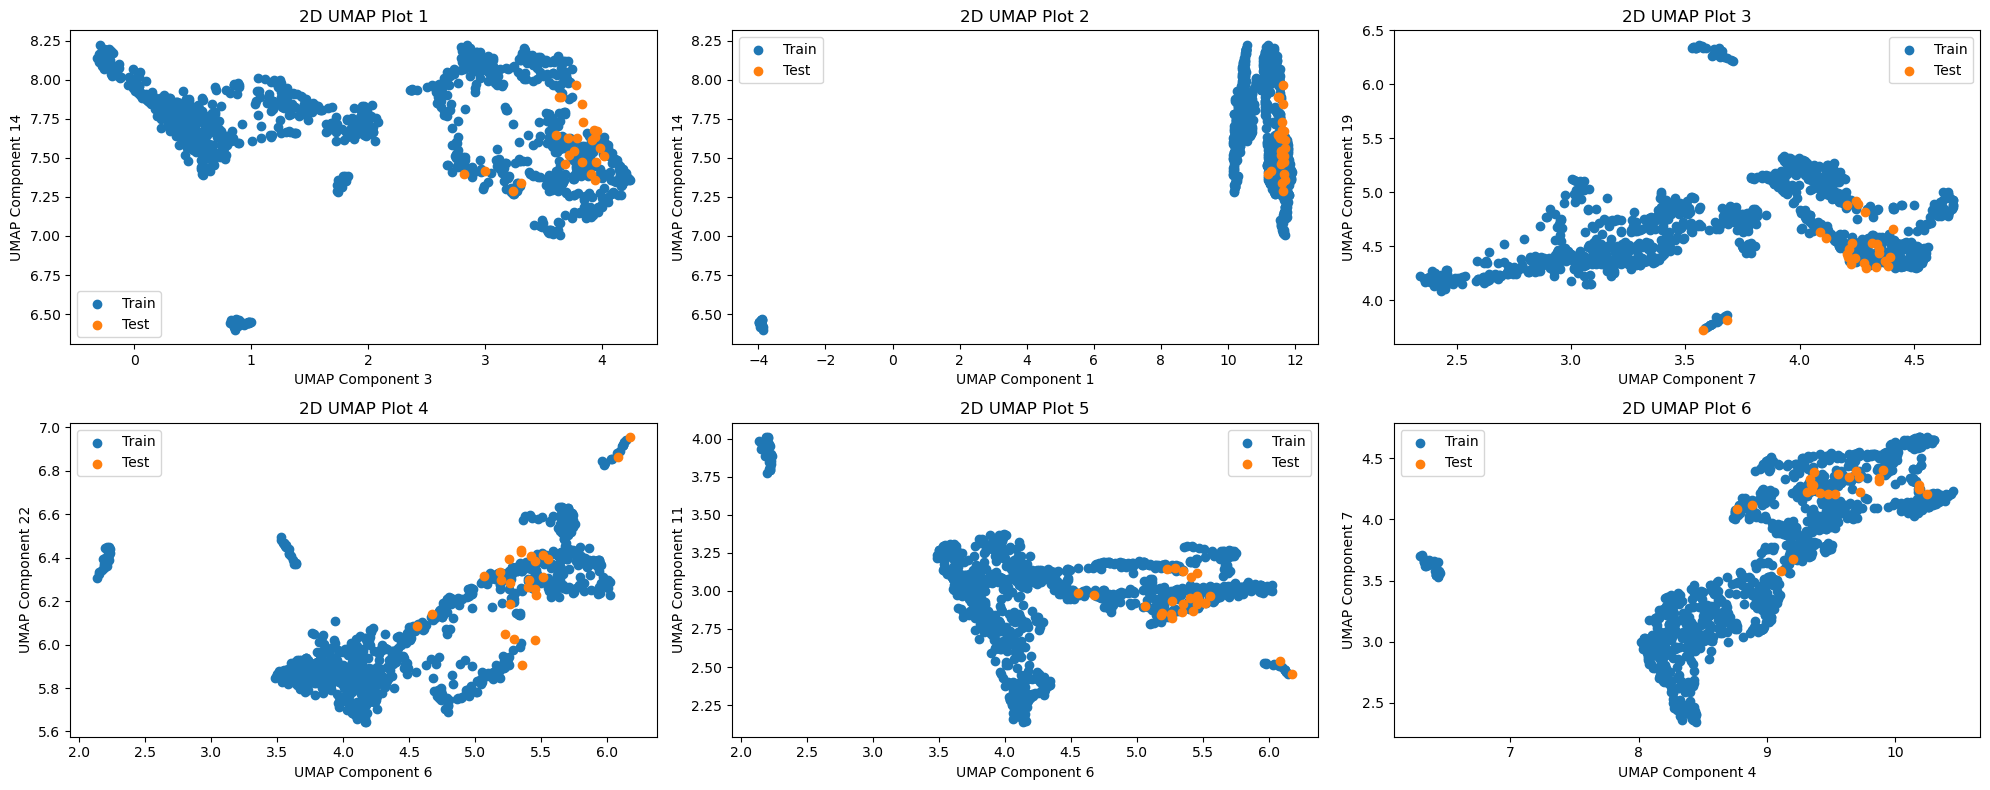

Shape of the reduced train data: (1145, 25)
Shape of the reduced test data: (25, 25)
Shape of the train data: (1145, 82)
Shape of the test data: (25, 82)


In [15]:
def perform_multiple_random_2d_umap_plots_and_dimensionality_reduction(X_train, y_train, X_test, y_test, columns_to_keep, n_components=30, random_state=42, plot_combinations=6):
    # 1. Apply UMAP
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    reduced_data_train = reducer.fit_transform(X_train)
    reduced_data_test = reducer.transform(X_test)

    # 2. Plot the 2D scatter plots for random component combinations
    component_indices = range(n_components)
    combinations = list(itertools.combinations(component_indices, 2))
    random.seed(random_state)
    selected_combinations = random.sample(combinations, plot_combinations)

    # Set the layout for subplots
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

    for idx, (c1, c2) in enumerate(selected_combinations):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        ax.scatter(reduced_data_train[:, c1], reduced_data_train[:, c2], label='Train')
        ax.scatter(reduced_data_test[:, c1], reduced_data_test[:, c2], label='Test')
        ax.set_xlabel(f'UMAP Component {c1 + 1}')
        ax.set_ylabel(f'UMAP Component {c2 + 1}')
        ax.set_title(f'2D UMAP Plot {idx + 1}')
        ax.legend()

    plt.tight_layout()
    plt.show()

    # 3. Print the shape of the reduced data
    print(f"Shape of the reduced train data: {reduced_data_train.shape}")
    print(f"Shape of the reduced test data: {reduced_data_test.shape}")

    # 4. Create DataFrames for the reduced data
    reduced_train_df = pd.DataFrame(reduced_data_train, columns=[f'UMAP{i + 1}' for i in range(n_components)], index=X_train.index)
    reduced_test_df = pd.DataFrame(reduced_data_test, columns=[f'UMAP{i + 1}' for i in range(n_components)], index=X_test.index)

    # 5. Concatenate the reduced data with the target variable and specified columns
    reduced_train_df = pd.concat([X_train[columns_to_keep], y_train, reduced_train_df], axis=1)
    reduced_test_df = pd.concat([X_test[columns_to_keep], y_test, reduced_test_df], axis=1)

    return reduced_train_df, reduced_test_df


def intersperse_columns(columns_to_keep_fixed, common_numerical_features, target_feature):

    # Initialize an empty list called combined_columns.
    combined_columns = []

    # Create a new list called common_numerical_features that contains all the elements from the original common_numerical_features list, except for the target_feature.
    # This is done using a list comprehension.
    common_numerical_features = [col for col in common_numerical_features if col != target_feature]

    # Create an empty set called added_features to keep track of the features added to combined_columns.
    added_features = set()

    # Iterate through the elements of columns_to_keep_fixed using a for loop. For each element (referred to as fixed_col):
    for fixed_col in columns_to_keep_fixed:
        # Append fixed_col to the combined_columns list and add it to the added_features set if it's not already in the set.
        if fixed_col not in added_features:
            combined_columns.append(fixed_col)
            added_features.add(fixed_col)
        # Check if there are still elements left in the common_numerical_features list. If so, pop the first element from the list and append it to combined_columns.
        while common_numerical_features:
            next_col = common_numerical_features.pop(0)
            if next_col not in added_features:
                combined_columns.append(next_col)
                added_features.add(next_col)
                break

    # Add any remaining common_numerical_features that are not already in added_features.
    for col in common_numerical_features:
        if col not in added_features:
            combined_columns.append(col)

    return combined_columns


def get_common_numerical_features(df1, df2, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Get numerical columns for each dataframe
    num_cols_df1 = set(df1.select_dtypes(include=[np.number]).columns) - set(exclude_columns)
    num_cols_df2 = set(df2.select_dtypes(include=[np.number]).columns) - set(exclude_columns)

    # Find the common numerical columns
    common_numerical_cols = list(num_cols_df1.intersection(num_cols_df2))

    return common_numerical_cols

common_numerical_features = get_common_numerical_features(df_eu, df_country, exclude_columns=columns_to_drop)
print("Common numerical features:", common_numerical_features)

new_columns_to_keep = intersperse_columns(columns_to_keep_fixed, common_numerical_features, agg_var_to_disagg)

print("New columns to keep:", new_columns_to_keep)

n_components = 25
reduced_train_df, reduced_test_df = perform_multiple_random_2d_umap_plots_and_dimensionality_reduction(X_train[new_columns_to_keep], y_train, X_test[new_columns_to_keep], y_test, new_columns_to_keep, n_components=n_components, random_state=42, plot_combinations=6)

print(f"Shape of the train data: {reduced_train_df.shape}")
print(f"Shape of the test data: {reduced_test_df.shape}")

In [16]:
reduced_train_df.shape

(1145, 82)

### Analysing the distribution and scale of the reduced features using descriptive statistics and box plots:

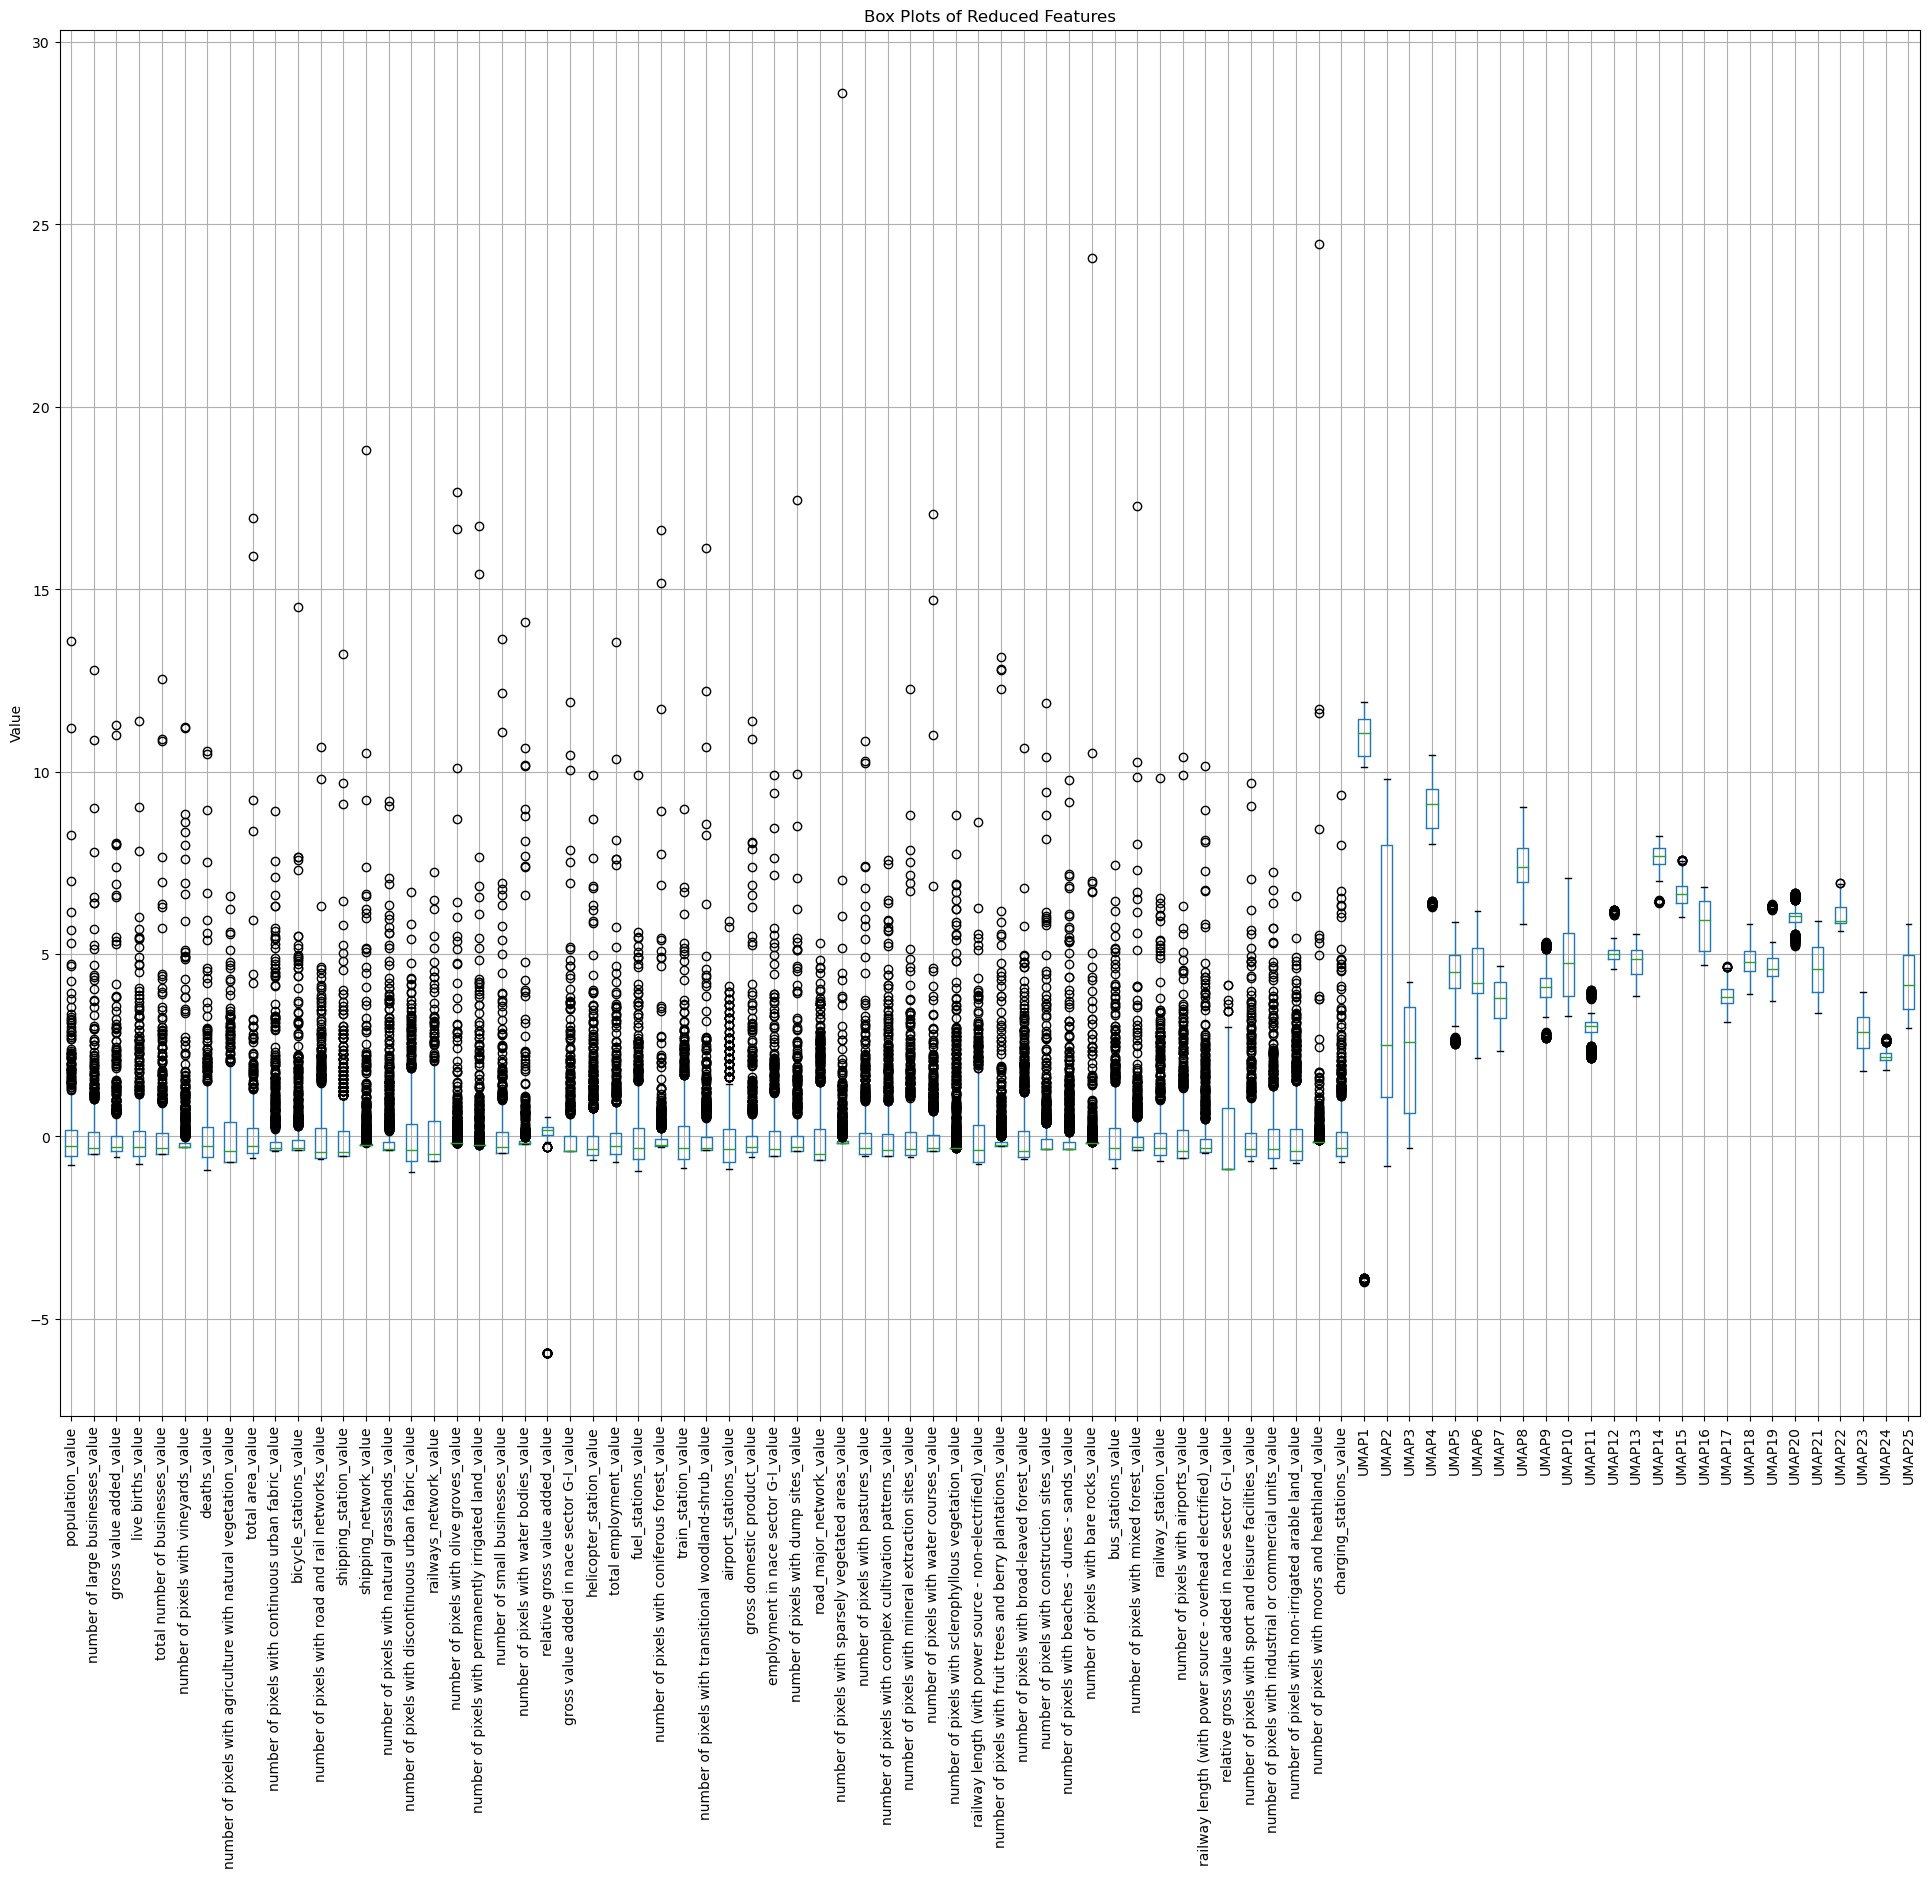

population_value  number of large businesses_value  \
0            -0.737458                         -0.395876   
1            -0.475706                         -0.090970   
2            -0.610286                         -0.281094   
3            -0.289477                          0.073871   
4            -0.260014                          0.047072   
...                ...                               ...   
1165          0.621491                          0.506201   
1166          0.658195                          0.559294   
1167          0.559552                          0.314054   
1168          0.945669                          0.499122   
1169          0.892789                          0.404060   

      gross value added_value  live births_value  \
0                   -0.516610          -0.725080   
1                   -0.306536          -0.490966   
2                   -0.433735          -0.623718   
3                   -0.147775          -0.242246   
4                   -0.156777          -0.273636   
...                       ...                ...   
1165                -0.093496           0.547073   
1166                -0.060292           0.844620   
1167                -0.183732           0.523094   
1168                -0.152647           1.381078   
1169                -0.043453           1.147400   

      total number of businesses_value  number of pixels with vineyards_value  \
0                            -0.422980                              -0.125258   
1                            -0.244557                               0.821307   
2                            -0.343771                              -0.199768   
3                            -0.186943                              -0.244195   
4                            -0.140835                              -0.166433   
...                                ...                                    ...   
1165                          1.018742                               0.143281   
1166                          1.223052                              -0.280434   
1167                          0.685745                              -0.122528   
1168                          1.154169                              -0.280434   
1169                          0.769633                              -0.143725   

      deaths_value  \
0        -0.856020   
1        -0.557523   
2        -0.688070   
3        -0.384195   
4        -0.294719   
...            ...   
1165      0.868955   
1166      0.648933   
1167      0.760655   
1168      0.730341   
1169      0.841085   

      number of pixels with agriculture with natural vegetation_value  \
0                                             -0.620453                 
1                                             -0.514576                 
2                                             -0.366300                 
3                                              0.862350                 
4                                             -0.083542                 
...                                                 ...                 
1165                                           0.602663                 
1166                                           1.169197                 
1167                                           3.447988                 
1168                                           2.451396                 
1169                                           0.905563                 

      total area_value  number of pixels with continuous urban fabric_value  \
0            -0.478605                                          -0.399095     
1            -0.296703                                          -0.243905     
2            -0.350223                                          -0.275887     
3            -0.035937                                          -0.165262     
4            -0.033937                                          -0.326219     
...                ...                                                .

In [17]:
def analyze_reduced_data(train_df, test_df):
    """
    Calculate descriptive statistics and visualize distributions of reduced features using box plots.

    Args:
    train_df (pd.DataFrame): Reduced train dataset.
    test_df (pd.DataFrame): Reduced test dataset.

    Returns:
    None
    """
    # Combine the train and test datasets
    combined_reduced_df = pd.concat([reduced_train_df, reduced_test_df])
    # Sort the DataFrame by index
    combined_reduced_df  = combined_reduced_df.sort_index()

    # Calculate descriptive statistics
    statistics = combined_reduced_df.describe().transpose()
    # print(statistics)

    # Visualize distributions using box plots
    plt.figure(figsize=(24, 18))
    combined_reduced_df.boxplot()
    plt.xticks(rotation=90)
    plt.title('Box Plots of Reduced Features')
    plt.ylabel('Value')
    plt.show()

    return combined_reduced_df

analyze_reduced_data(reduced_train_df, reduced_test_df)

        We can see that the mean and standard deviation values for the initial features are near 0 and 1, respectively, which indicates that they have been standardized already. The UMAP components, however, show a different scale, with means ranging from 2.69 to 6.40 and standard deviations ranging from 0.14 to 0.34.

        Since the scales of the UMAP components are different from the initial features, it may be beneficial to standardize the UMAP components before clustering. 

#### Function to Standarize UMAP components

In [18]:
def standardize_umap_components(train_df, test_df):
    """
    Standardize UMAP components in train and test datasets.

    Args:
    train_df (pd.DataFrame): Reduced train dataset.
    test_df (pd.DataFrame): Reduced test dataset.

    Returns:
    (pd.DataFrame, pd.DataFrame): Scaled train and test datasets.
    """
    # Get UMAP feature columns
    umap_columns = [col for col in train_df.columns if col.startswith('UMAP')]

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Scale UMAP components in train data
    train_df[umap_columns] = scaler.fit_transform(train_df[umap_columns])

    # Scale UMAP components in test data
    test_df[umap_columns] = scaler.transform(test_df[umap_columns])

    return train_df, test_df

reduced_train_df, reduced_test_df = standardize_umap_components(reduced_train_df, reduced_test_df)


In [19]:
analyze_reduced_data(reduced_train_df, reduced_test_df)

population_value  number of large businesses_value  \
0            -0.737458                         -0.395876   
1            -0.475706                         -0.090970   
2            -0.610286                         -0.281094   
3            -0.289477                          0.073871   
4            -0.260014                          0.047072   
...                ...                               ...   
1165          0.621491                          0.506201   
1166          0.658195                          0.559294   
1167          0.559552                          0.314054   
1168          0.945669                          0.499122   
1169          0.892789                          0.404060   

      gross value added_value  live births_value  \
0                   -0.516610          -0.725080   
1                   -0.306536          -0.490966   
2                   -0.433735          -0.623718   
3                   -0.147775          -0.242246   
4                   -0.156777          -0.273636   
...                       ...                ...   
1165                -0.093496           0.547073   
1166                -0.060292           0.844620   
1167                -0.183732           0.523094   
1168                -0.152647           1.381078   
1169                -0.043453           1.147400   

      total number of businesses_value  number of pixels with vineyards_value  \
0                            -0.422980                              -0.125258   
1                            -0.244557                               0.821307   
2                            -0.343771                              -0.199768   
3                            -0.186943                              -0.244195   
4                            -0.140835                              -0.166433   
...                                ...                                    ...   
1165                          1.018742                               0.143281   
1166                          1.223052                              -0.280434   
1167                          0.685745                              -0.122528   
1168                          1.154169                              -0.280434   
1169                          0.769633                              -0.143725   

      deaths_value  \
0        -0.856020   
1        -0.557523   
2        -0.688070   
3        -0.384195   
4        -0.294719   
...            ...   
1165      0.868955   
1166      0.648933   
1167      0.760655   
1168      0.730341   
1169      0.841085   

      number of pixels with agriculture with natural vegetation_value  \
0                                             -0.620453                 
1                                             -0.514576                 
2                                             -0.366300                 
3                                              0.862350                 
4                                             -0.083542                 
...                                                 ...                 
1165                                           0.602663                 
1166                                           1.169197                 
1167                                           3.447988                 
1168                                           2.451396                 
1169                                           0.905563                 

      total area_value  number of pixels with continuous urban fabric_value  \
0            -0.478605                                          -0.399095     
1            -0.296703                                          -0.243905     
2            -0.350223                                          -0.275887     
3            -0.035937                                          -0.165262     
4            -0.033937                                          -0.326219     
...                ...                                                .

## Feature Selection

        This code includes feature selection methods such as correlation matrix, univariate feature selection (F-Regression and Mutual Information), Lasso (L1 Regularization), Ridge (L2 Regularization), and Random Forest Importance.

        The final step combines the selected features from different methods and calculates the cross-validation scores with all features and selected features. You can compare these scores to decide whether to use all features or only the selected ones.

Number of Highly correlated features selected by correlation_matrix:  8
Highly correlated features: ['gross value added_value', 'live births_value', 'total employment_value', 'train_station_value', 'gross domestic product_value', 'bus_stations_value', 'railway_station_value', 'number of pixels with industrial or commercial units_value']
Correlation matrix for Most Correlated Variables 1-8 - EU:


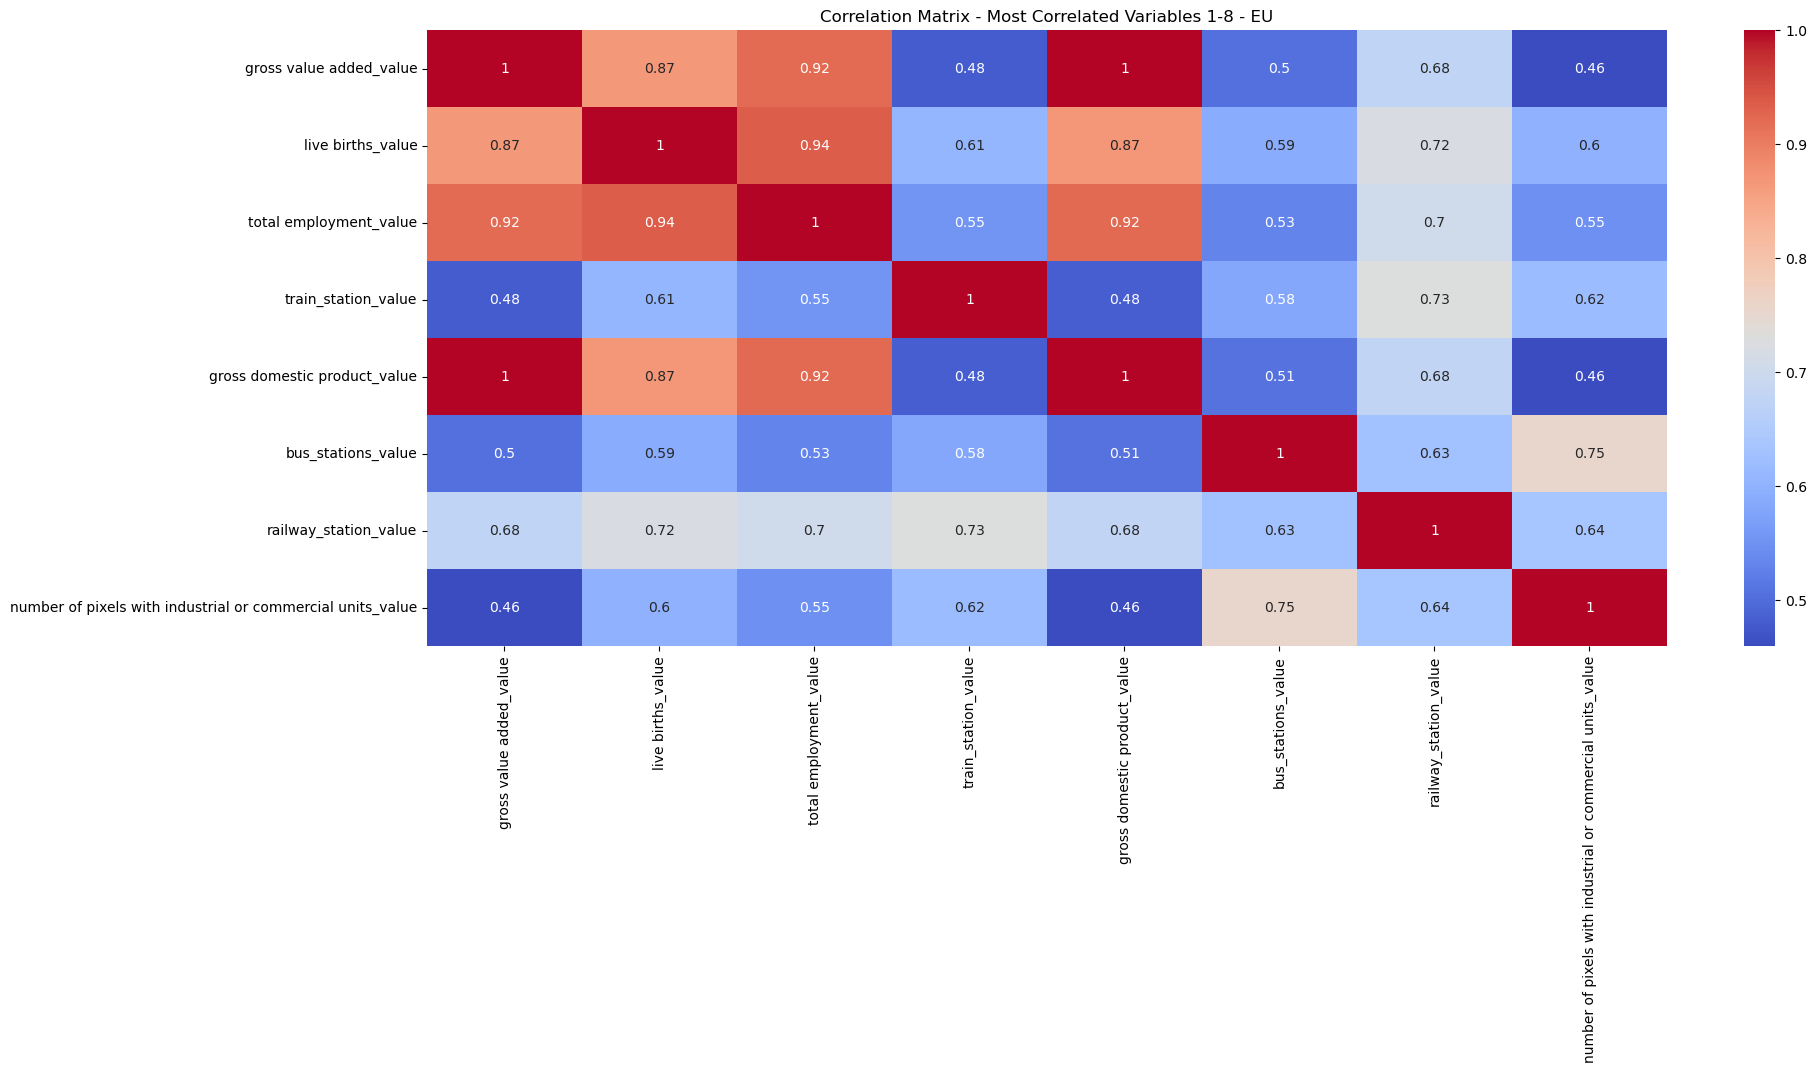

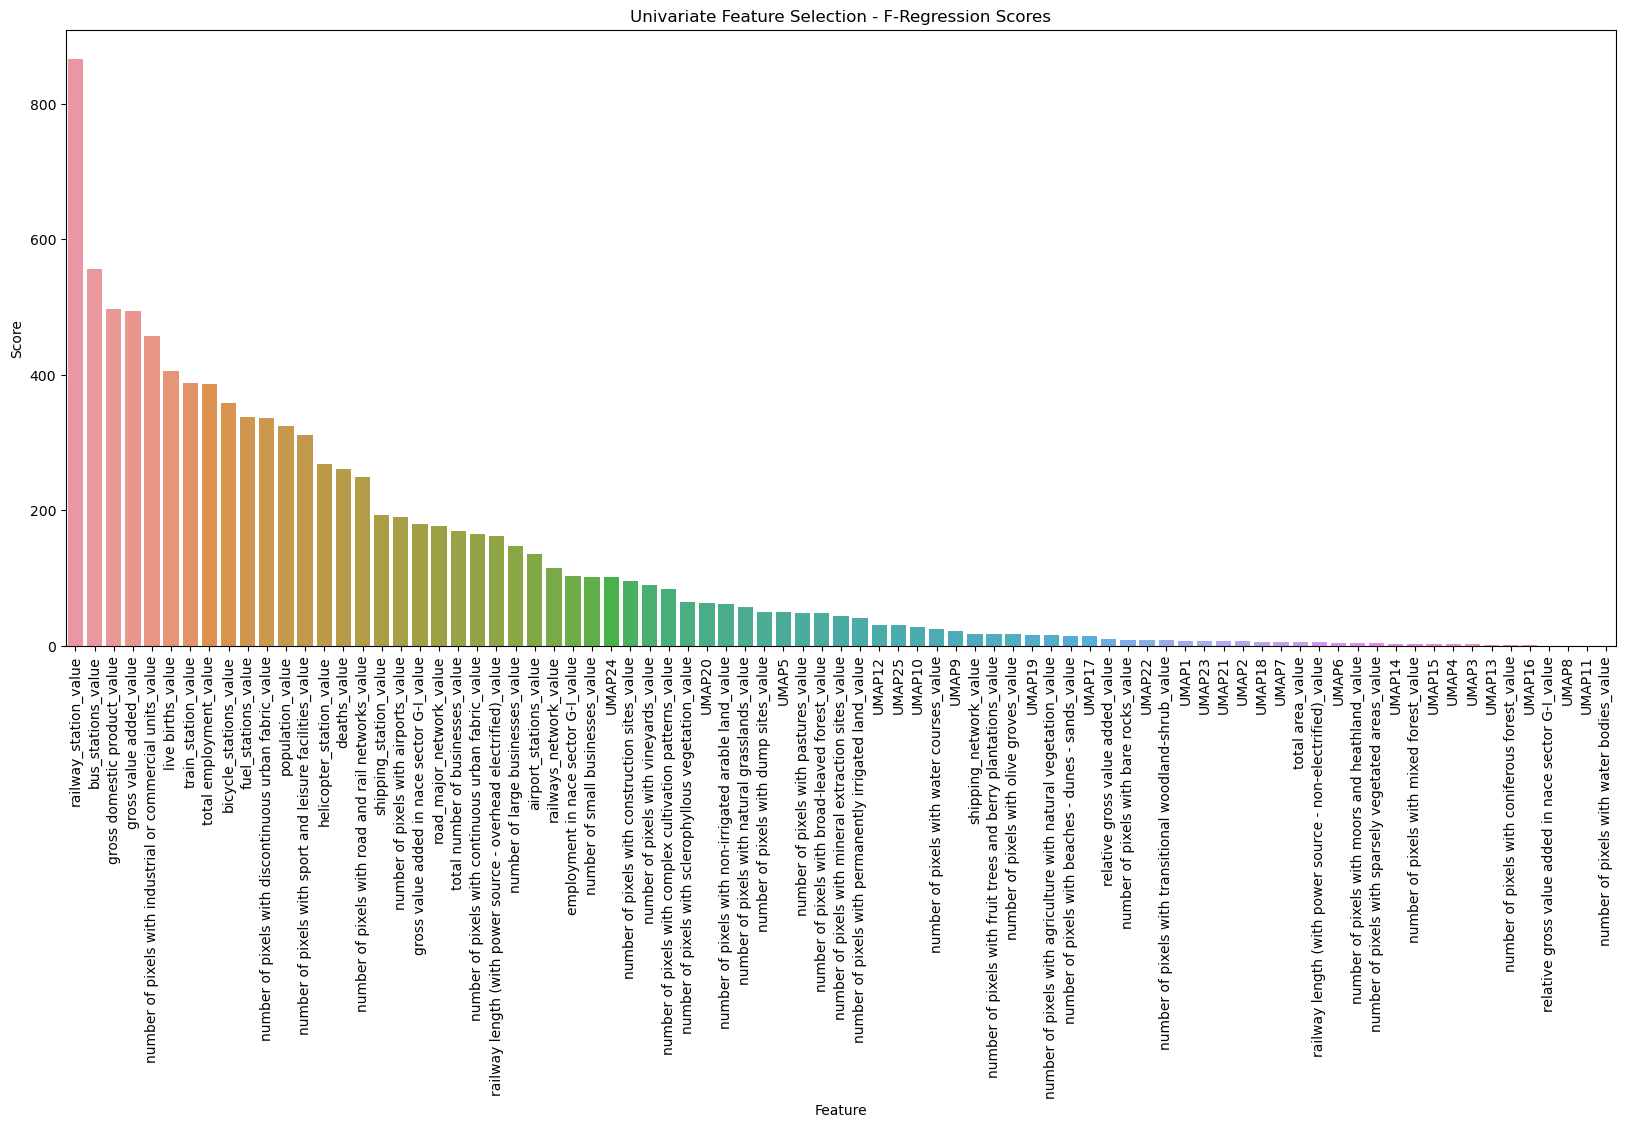

Number of selected k features based by univariate F-Regression:  4
Top k features based on F-Regression: ['railway_station_value', 'bus_stations_value', 'gross domestic product_value', 'gross value added_value']


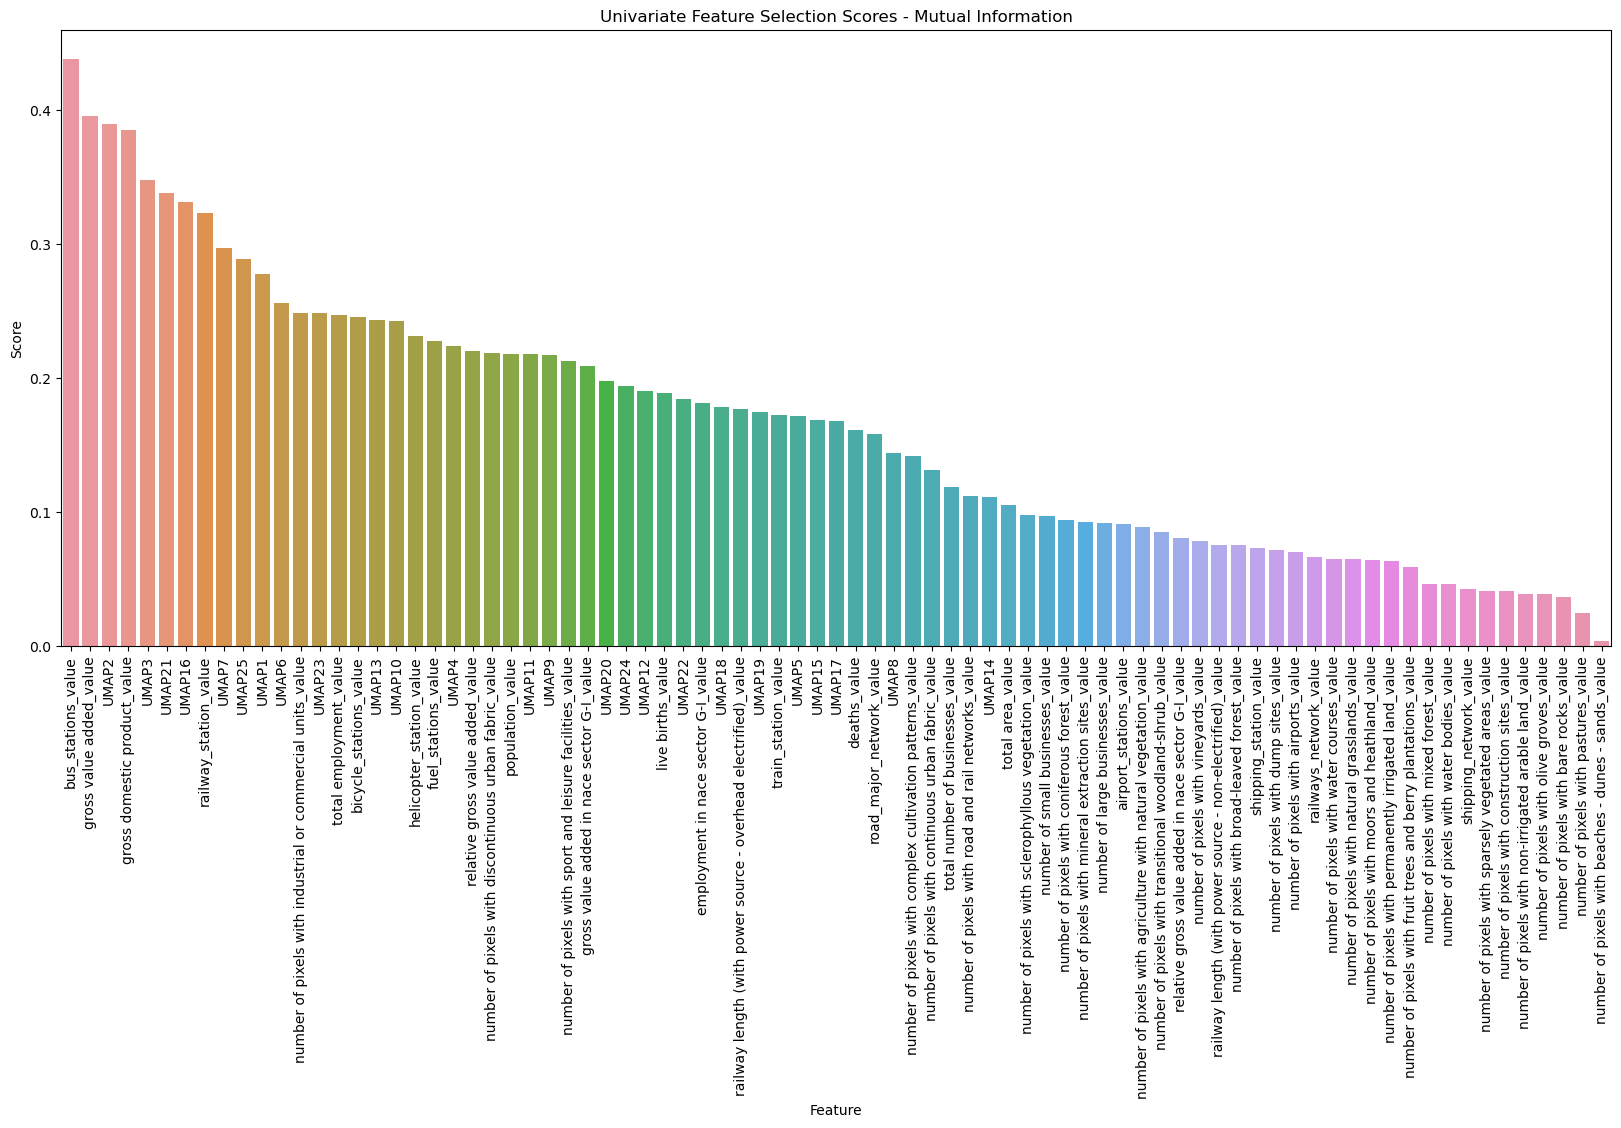

Number of selected k features based by univariate Mutual Information:  4
Top k features based on Mutual Information: ['bus_stations_value', 'gross value added_value', 'UMAP2', 'gross domestic product_value', 'UMAP3', 'UMAP21', 'UMAP16', 'railway_station_value', 'UMAP7', 'UMAP25']


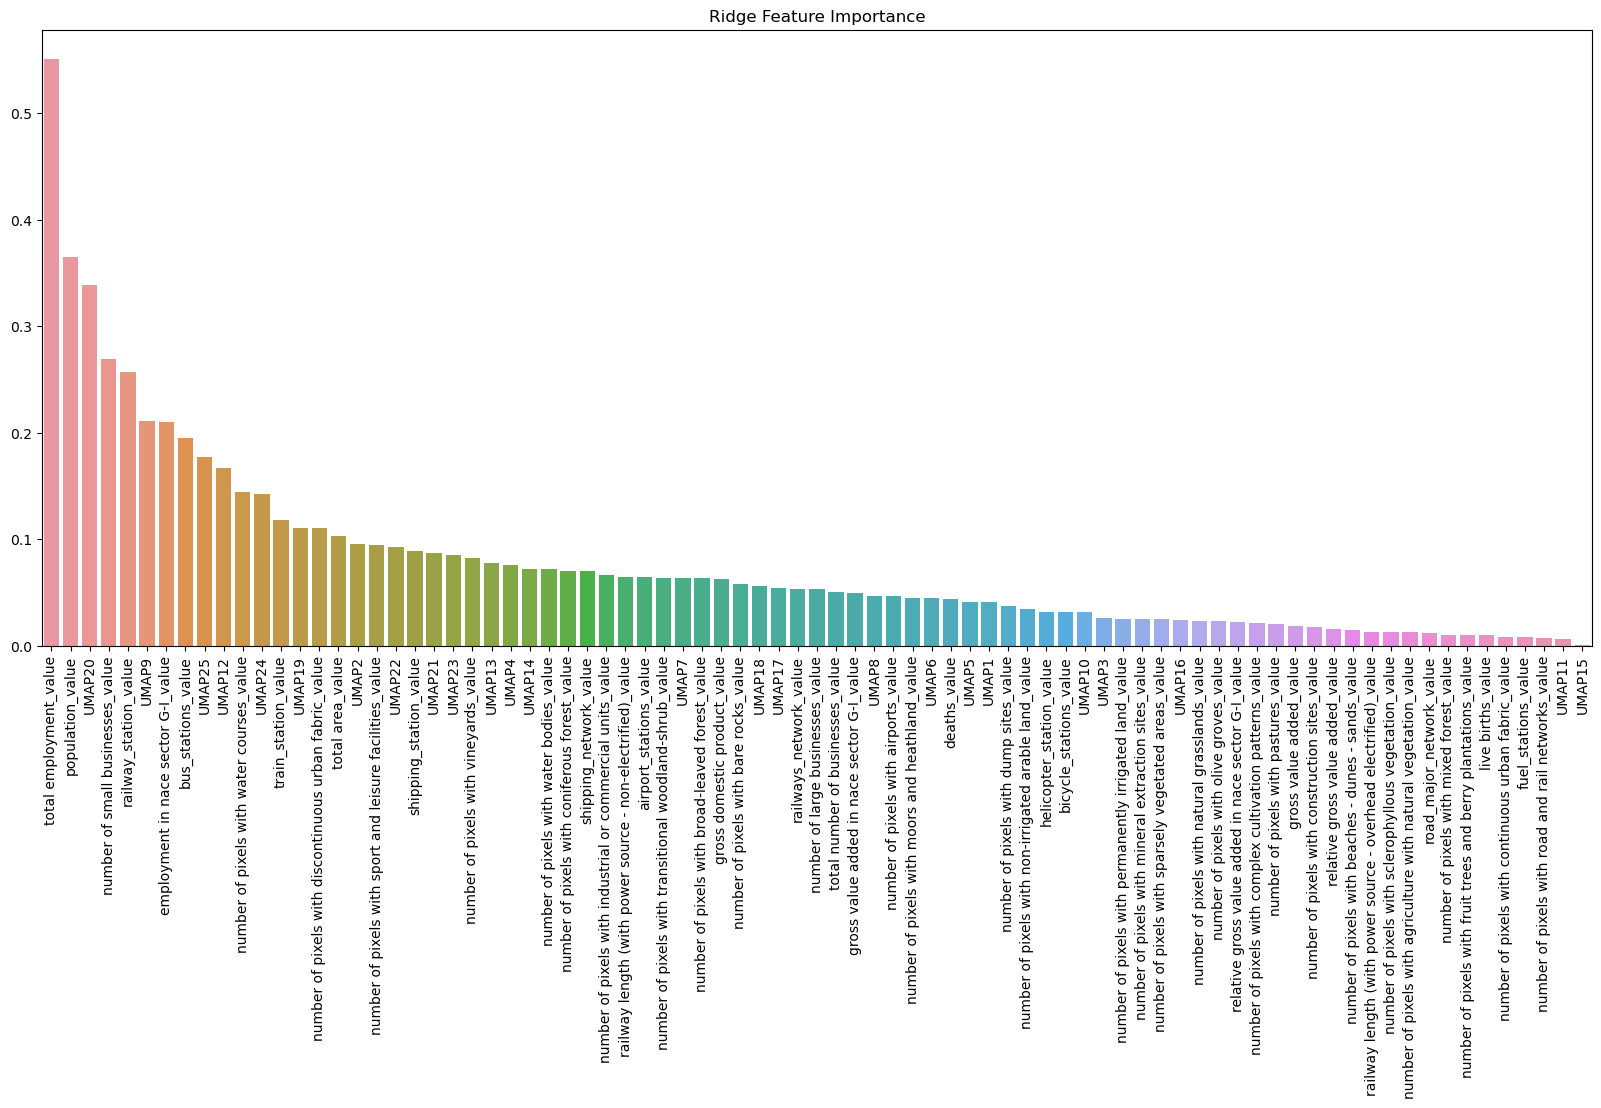

Number of selected features by Ridge (L2 Regularization): 5
Top 5 selected features based on Ridge (L2 Regularization) : 
['total employment_value', 'population_value', 'UMAP20', 'number of small businesses_value', 'railway_station_value']
--------------------------------------------------------------------------------------------------
selected_features_3:  ['total employment_value', 'population_value', 'UMAP20', 'number of small businesses_value', 'railway_station_value']
Number of selected features:  5


Number of selected features by Random Forest : 4
Top 4 features based on Random Forest : ['railway_station_value', 'gross value added_value', 'shipping_station_value', 'bus_stations_value']
--------------------------------------------------------------------------------------------------
selected_features:  ['gross value added_value', 'live births_value', 'bus_stations_value', 'UMAP7', 'UMAP3', 'shipping_station_value', 'railway_station_value', 'number of pixels with industrial or commercial units_value', 'UMAP20', 'train_station_value', 'number of small businesses_value', 'UMAP2', 'UMAP21', 'UMAP16', 'gross domestic product_value', 'population_value', 'UMAP25', 'total employment_value']
Numbeer of selected features:  18
--------------------------------------------------------------
Linear Regression
Cross-validation score with all features: -0.041924306782479756
Cross-validation score with selected features: 0.27893968358035115
---------------------------------------------------------

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rofer\anaconda3

--------------------------------------------------------------
MLP Regressor
Cross-validation score with all features: 0.2350282940999185
Cross-validation score with selected features: 0.43499633467233717
--------------------------------------------------------------
Average cross-validation score across all models with all features_score: 0.21945912922310162
Average cross-validation score across all models with selected_features_score: 0.32215708436834467


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
# Define X_train, y_train, X_test, and y_test from your reduced_train_df and reduced_test_df
X_train = reduced_train_df.drop(agg_var_to_disagg, axis=1)
y_train = reduced_train_df[agg_var_to_disagg]
X_test = reduced_test_df.drop(agg_var_to_disagg, axis=1)
y_test = reduced_test_df[agg_var_to_disagg]

# 1. Correlation Matrix
def correlation_matrix(X_train, y_train, threshold):
    corr = pd.concat([X_train, y_train], axis=1).corr()

    # Filter features with correlation higher than the threshold
    high_corr_features = [column for column in corr.columns if abs(corr.loc[agg_var_to_disagg, column]) > threshold and column != agg_var_to_disagg]
    return high_corr_features

high_corr_features = correlation_matrix(X_train, y_train, threshold=0.50)
print('Number of Highly correlated features selected by correlation_matrix: ', len(high_corr_features))
print("Highly correlated features:", high_corr_features)

def plot_most_correlated_eu(dataframe, most_correlated_list, fig_size=(20, 8)):
    """
    Plot a correlation matrix for the most correlated columns in a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    most_correlated_list (list): A list of column names to include in the correlation matrix.
    fig_size (tuple): The size of the figure in inches (default: (8, 6)).

    Returns:
    None
    """
    # Split list of most correlated variables into sublists of length 20
    sublists = [most_correlated_list[i:i+10] for i in range(0, len(most_correlated_list), 10)]

    # Plot correlation matrix for each sublist of variables
    for i, sublist in enumerate(sublists):
        fig_title = f"Most Correlated Variables {i+1}-{i+len(sublist)} - EU"
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'correlation_matrix',
                                             'EU',
                                             f"{fig_title}.png")
        df = dataframe[sublist]
        corr = df.corr()
        print(f"Correlation matrix for {fig_title}:")
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
        ax.set_title(f'Correlation Matrix - {fig_title}')

        # # Save data to file if it doesn't exist
        # plt.savefig(file_path_destination)

        plt.show()

plot_most_correlated_eu(pd.concat([X_train, y_train], axis=1), high_corr_features)


# 2. Univariate Feature Selection F-Regression
def univariate_feature_selection_f_regression(X_train, y_train, k, score_func=f_regression):
    selector = SelectKBest(score_func=score_func, k=k)
    selector.fit(X_train, y_train)

    scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
    scores.sort_values(by='Score', ascending=False, inplace=True)

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Feature', y='Score', data=scores)
    plt.xticks(rotation=90)
    plt.title('Univariate Feature Selection - F-Regression Scores')
    plt.show()

    # Filter the top k features
    top_k_features = scores['Feature'].head(k).tolist()
    return top_k_features

top_k_features = univariate_feature_selection_f_regression(X_train, y_train, k=4, score_func=f_regression)
print('Number of selected k features based by univariate F-Regression: ', len(top_k_features))
print("Top k features based on F-Regression:", top_k_features)


# 3. Univariate Feature Selection Mutual Information
def univariate_feature_selection_mutual_information(X_train, y_train, k, score_func=f_regression):
    selector = SelectKBest(score_func=score_func, k=k)
    selector.fit(X_train, y_train)

    scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector.scores_})
    scores.sort_values(by='Score', ascending=False, inplace=True)

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Feature', y='Score', data=scores)
    plt.xticks(rotation=90)
    plt.title('Univariate Feature Selection Scores - Mutual Information')
    plt.show()

    # Filter the top k features
    top_k_features = scores['Feature'].head(k).tolist()
    return top_k_features

top_k_features_mutual_info = univariate_feature_selection_mutual_information(X_train, y_train, k=10, score_func=mutual_info_regression)
print('Number of selected k features based by univariate Mutual Information: ', len(top_k_features))
print("Top k features based on Mutual Information:", top_k_features_mutual_info)


# # 3. Lasso (L1 Regularization)
# def lasso_feature_selection(X_train, y_train):
#     lasso = LassoCV(cv=5, random_state=42, max_iter=10000, tol=1e-4)
#     lasso.fit(X_train, y_train)

#     coef = pd.Series(lasso.coef_, index=X_train.columns)
#     selected_features = coef[coef != 0].index.tolist()

#     plt.figure(figsize=(12, 6))
#     sns.barplot(x=coef.index, y=coef.values)
#     plt.xticks(rotation=90)
#     plt.title('Lasso Feature Importance')
#     plt.show()

#     return selected_features

# selected_features_lasso = lasso_feature_selection(X_train, y_train)
# print('Number of selected features by Lasso (L1 Regularization: ', len(selected_features_lasso))
# print("Features selected by Lasso (L1 Regularization):", selected_features_lasso)


# 4. Ridge (L2 Regularization)
def ridge_feature_selection(X_train, y_train, top_k):
    ridge = RidgeCV(cv=5)
    ridge.fit(X_train, y_train)

    coef = pd.Series(ridge.coef_, index=X_train.columns)
    coef_sorted = coef.abs().sort_values(ascending=False)

    plt.figure(figsize=(20, 8))
    sns.barplot(x=coef_sorted.index, y=coef_sorted.values)
    plt.xticks(rotation=90)
    plt.title('Ridge Feature Importance')
    plt.show()

    # Print the number of selected features and their length
    num_selected_features = len(coef_sorted[:top_k])
    print(f"Number of selected features by Ridge (L2 Regularization): {num_selected_features}")
    print(f"Top {top_k} selected features based on Ridge (L2 Regularization) : ")
    print(coef_sorted[:top_k].index.tolist())

    return coef_sorted[:top_k]

ridge_importance = ridge_feature_selection(X_train, y_train, top_k=5)

# Get the selected features from Ridge regularization
selected_features_ridge = list(ridge_importance.index)
print('--------------------------------------------------------------------------------------------------')
print('selected_features_3: ', selected_features_ridge)
print('Number of selected features: ', len(selected_features_ridge))

# 5. Random Forest Importance
def random_forest_feature_importance(X_train, y_train, top_k):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    importance = pd.Series(rf.feature_importances_, index=X_train.columns)
    importance.sort_values(ascending=False, inplace=True)

    # Select the top K features
    top_k_importance = importance[:top_k]

    plt.figure(figsize=(20, 8))
    sns.barplot(x=importance.index, y=importance.values)
    plt.xticks(rotation=90)
    plt.title(f'Random Forest Feature Importance')
    plt.show()

    # Print the number of selected features and their length
    num_selected_features = len(top_k_importance)
    print(f"Number of selected features by Random Forest : {num_selected_features}")
    print(f"Top {num_selected_features} features based on Random Forest : {top_k_importance.index.tolist()}")

    return top_k_importance.index.tolist()

rf_importance = random_forest_feature_importance(X_train, y_train, top_k=4)

# 6. Combine selected features from different methods
selected_features = list(set(high_corr_features + top_k_features + top_k_features_mutual_info + selected_features_ridge + rf_importance))
print('--------------------------------------------------------------------------------------------------')
print('selected_features: ', selected_features)
print('Numbeer of selected features: ', len(selected_features))

selected_features = selected_features

# 7. Perform cross-validation with selected feature
# Define the models to train
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector': SVR(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'MLP Regressor': MLPRegressor(random_state=42)
}

# Perform cross-validation with all and selected features for each model
results_all_features = []
results_selected_features = []
for name, model in models.items():
    # Cross-validation score with all features
    all_features_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))

    # Cross-validation score with selected features
    selected_features_score = np.mean(cross_val_score(model, X_train[selected_features], y_train, cv=5))

    # Print the results
    print('--------------------------------------------------------------')
    print(name)
    print("Cross-validation score with all features:", all_features_score)
    print("Cross-validation score with selected features:", selected_features_score)

    results_all_features.append(all_features_score)
    results_selected_features.append(selected_features_score)

# Print average score
print('--------------------------------------------------------------')
print('Average cross-validation score across all models with all features_score:', np.mean(results_all_features))
print('Average cross-validation score across all models with selected_features_score:', np.mean(results_selected_features))

## Cluster

        To find the optimal number of clusters for your data, you can use the elbow method and silhouette scores to evaluate different numbers of clusters. Here is a step-by-step guide for applying the KMeans clustering algorithm and determining the optimal number of clusters:

#### 1.Import necessary libraries:


In [21]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

### 2.Prepare the data:

        Since clustering algorithms generally work with numerical data, make sure your DataFrame only contains numerical columns. Also, it's essential to scale the data before applying the clustering algorithm.

In [22]:
# Combine the train and test datasets
X_combined = pd.concat([X_train, X_test])
# Sort the DataFrame by index
X_combined = X_combined.sort_index()
# Select the features
X_combined_selected = X_combined[selected_features]

In [23]:
X_combined_selected = check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(X_combined_selected)

The number of rows with NaN values in column gross value added_value is 0
The number of rows with NaN values in column live births_value is 0
The number of rows with NaN values in column bus_stations_value is 0
The number of rows with NaN values in column UMAP7 is 0
The number of rows with NaN values in column UMAP3 is 0
The number of rows with NaN values in column shipping_station_value is 0
The number of rows with NaN values in column railway_station_value is 0
The number of rows with NaN values in column number of pixels with industrial or commercial units_value is 0
The number of rows with NaN values in column UMAP20 is 0
The number of rows with NaN values in column train_station_value is 0
The number of rows with NaN values in column number of small businesses_value is 0
The number of rows with NaN values in column UMAP2 is 0
The number of rows with NaN values in column UMAP21 is 0
The number of rows with NaN values in column UMAP16 is 0
The number of rows with NaN values in colum

### 3.Determine the range of cluster numbers you want to test:

In [24]:
cluster_range = range(2, 10)  # Test from 3 to 5 clusters

### 4.Calculate the Within Cluster Sum of Squares (WCSS) and silhouette scores for each number of clusters:

In [25]:
# wcss = []
# silhouette_scores = []

# for n_clusters in cluster_range:
#     kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=15, max_iter=500000, tol=1e-4, random_state=42)
#     kmeans.fit(X_combined_selected)
#     wcss.append(kmeans.inertia_)
#     cluster_labels = kmeans.predict(X_combined_selected)
#     silhouette_scores.append(silhouette_score(X_combined_selected, cluster_labels))

In [26]:
# wcss

In [27]:
# silhouette_scores

### 5.Plot the elbow curve to visualize the optimal number of clusters:

In [28]:
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range, wcss, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.title('Elbow Curve')
# plt.show()

### 6.Plot the silhouette scores to further evaluate the optimal number of clusters:

In [29]:
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Scores')
# plt.show()

### 7.Choose the optimal number of clusters based on the elbow curve and silhouette scores.

In [30]:
optimal_clusters = 3

### 8.Fit the KMeans algorithm with the optimal number of clusters and assign the cluster labels to each instance:

In [31]:
# kmeans_optimal = KMeans(n_clusters=optimal_clusters, init='k-means++', n_init=15, max_iter=500000, tol=1e-4, random_state=42)
# kmeans_optimal.fit(X_combined_selected)
# cluster_labels = kmeans_optimal.predict(X_combined_selected)

### 9.Add the cluster labels to the DataFrame:

In [32]:
# # Create a new DataFrame from X_combined_selected
# X_combined_selected_modified = X_combined_selected.copy()

# # Assign cluster labels to the new DataFrame
# X_combined_selected_modified.loc[:, 'Cluster'] = cluster_labels

# Concatenate y_train and y_test
y_combined = pd.concat([y_train, y_test], axis=0)

# Sort y_combined by index
y_combined_sorted = y_combined.sort_index()

# Create a new DataFrame for y_combined_sorted
y_combined_sorted_df = pd.DataFrame(y_combined_sorted, columns=[agg_var_to_disagg])

# Combine the DataFrames
# df = pd.concat([df_eu.iloc[:, :5], y_combined_sorted_df, X_combined_selected_modified], axis=1)
df = pd.concat([df_eu.iloc[:, :5], y_combined_sorted_df, X_combined_selected], axis=1)

### 10.Separate the dataframe into different clusters

In [33]:
def separate_clusters(df):
    if 'Cluster' not in df.columns:
        df['Cluster'] = 0

    clusters = df['Cluster'].unique()
    cluster_dfs = {}

    for i, cluster in enumerate(clusters):
        cluster_name = f'df_cluster_{i}'
        cluster_df = df.loc[df['Cluster'] == cluster].copy()
        cluster_df['Cluster'] = i
        cluster_dfs[cluster_name] = cluster_df

    return cluster_dfs


cluster_dfs = separate_clusters(df)
n_clusters = len(cluster_dfs)
cluster_names = list(cluster_dfs.keys())

df_cluster_0 = cluster_dfs.get('df_cluster_0', None)
df_cluster_1 = cluster_dfs.get('df_cluster_1', None)
df_cluster_2 = cluster_dfs.get('df_cluster_2', None)
df_cluster_3 = cluster_dfs.get('df_cluster_3', None)
df_cluster_4 = cluster_dfs.get('df_cluster_4', None)

# Access the first cluster name and its corresponding DataFrame
first_cluster_name = cluster_names[0]
df_cluster_0 = cluster_dfs[first_cluster_name]

try:
    # Access the second cluster name and its corresponding DataFrame
    second_cluster_name = cluster_names[1]
    df_cluster_1 = cluster_dfs[second_cluster_name]
except IndexError:
    pass

try:
    # Access the third cluster name and its corresponding DataFrame
    third_cluster_name = cluster_names[2]
    df_cluster_2 = cluster_dfs[third_cluster_name]
except IndexError:
    pass

try:
    # Access the fourth cluster name and its corresponding DataFrame
    fourth_cluster_name = cluster_names[3]
    df_cluster_3 = cluster_dfs[fourth_cluster_name]
except IndexError:
    pass

try:
    # Access the fifth cluster name and its corresponding DataFrame
    fifth_cluster_name = cluster_names[4]
    df_cluster_4 = cluster_dfs[fifth_cluster_name]
except IndexError:
    pass

In [34]:
print('shape of first cluster: ', df_cluster_0.shape)
try:
    print('shape of second cluster: ', df_cluster_1.shape)
except:
    pass
try:
    print('shape of third cluster: ', df_cluster_2.shape)
except:
    pass

shape of first cluster:  (1170, 25)


In [35]:
df_cluster_0.iloc[122:123]

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
122             EU                DE               DE1              DE11   

    NUTS3_region_code  charging_stations_value  gross value added_value  \
122             DE111                 3.074083                 2.220397   

     live births_value  bus_stations_value    UMAP7  ...  train_station_value  \
122            0.69225           -0.266413 -1.23419  ...            -0.259784   

     number of small businesses_value     UMAP2    UMAP21    UMAP16  \
122                         -0.453707  0.864817 -0.591525 -1.220526   

     gross domestic product_value  population_value    UMAP25  \
122                      2.205994           0.53957  0.114656   

     total employment_value  Cluster  
122                1.495367        0  

[1 rows x 25 columns]

# Master Dataframe Preparation

In [36]:
def create_master_dataframe_based_on_population_weights_v2(df, first_five_columns_df, feature_names, agg_var_to_disagg, region, predicted_values=None):

    # Check if there is a column named 'index' and drop it if necessary
    if 'index' in df.columns:
        df = df.drop(columns='index')

    # Append the "region_columns" dataframe to the main features dataframe
    df = pd.concat([first_five_columns_df, df], axis=1)

    # Extract the "aggregated_metric" column as a new dataframe
    aggregated_metric = df.loc[:, f"{agg_var_to_disagg}"].copy()
    aggregated_metric_df = pd.concat([first_five_columns_df, pd.DataFrame(aggregated_metric)], axis=1)

    # Extract the "aggregated_metric_df" column as two new dataframes: The real variable at NUTS3 level. Target to disaggregate.
    df_eu_apply_target = aggregated_metric_df.copy()
    df_eu_apply_target = df_eu_apply_target.rename(columns={df_eu_apply_target.columns[5]: 'target_variable'})
    # Add the index as a column to the EU target DataFrame
    df_eu_apply_target['index'] = df_eu_apply_target.index
    df_region_apply_target = df_eu_apply_target.loc[df_eu_apply_target ['NUTS0_region_code'] == region, :].copy()

    # Remove the "aggregated_metric" column from the main dataframe
    df = df.drop(columns=[f"{agg_var_to_disagg}"])

    # Remove "aggregated_metric" from the feature_names list
    print('The length of all ancilliary features + the aggregated feature is: ', len(feature_names))
    feature_names = [f for f in feature_names if f != f"{agg_var_to_disagg}"]
    print('The length of all ancilliary features is: ', len(feature_names))

    # Compute the population weights
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    df.reset_index(drop=True, inplace=True)
    metric_weight_df = df.iloc[:, :5].copy()  # select first 5 columns and make a copy

    # Calculate population weights
    population_weights = df.groupby('NUTS0_region_code', group_keys=False)['population_value'].apply(lambda x: x / x.sum().round(4)).reset_index(drop=True)
    # Assign population weights to the metric_weight_df
    metric_weight_df['population_weight'] = population_weights

    # Compute the sum of the agg_var_to_disagg at country level (variable that want to be disaggregated)
    agg_metric_country_value = aggregated_metric_df.groupby('NUTS0_region_code').agg({f'{agg_var_to_disagg}': 'sum'}).reset_index(drop=False)

    # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate population)
    agg_metric_pseudo_value = metric_weight_df.merge(agg_metric_country_value, on=['NUTS0_region_code'], how='left')[[f'{agg_var_to_disagg}', 'population_weight']].prod(axis=1).groupby(level=0).sum()

    agg_metric_pseudo_value = pd.DataFrame(agg_metric_pseudo_value, columns=[f"{agg_var_to_disagg}"])
    agg_metric_pseudo_value.reset_index(drop=True, inplace=True)

    # Extract the metric disaggregated at NUTS3 level from the pseudo value from population_weight as the first initial disaggregated method
    first_five_columns_df.reset_index(drop=True, inplace=True)
    disagg_metric_population_all = pd.concat([first_five_columns_df, agg_metric_pseudo_value], axis=1).copy()
    disagg_metric_population_all = disagg_metric_population_all.rename(columns={disagg_metric_population_all.columns[5]: 'target_variable'})
    disagg_metric_population_all['index'] = disagg_metric_population_all.index

    # Filter the disagg_metric_population_all DataFrame to get the disaggregated metric for the specified region
    disagg_metric_population = disagg_metric_population_all[disagg_metric_population_all['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    # Extract the disaggregated metric for the entire EU
    disagg_metric_population_eu = disagg_metric_population_all.copy()

    # Combine all the dataframes to start the creation of the master dataframe
    df_apply_eu = pd.concat([first_five_columns_df, df[feature_names], agg_metric_pseudo_value], axis=1)
    # Add the index as a column to the EU target DataFrame
    df_apply_eu['index'] = df_apply_eu.index
    # Filter the master_df to only include NUTS_0 regions that start with 'DE'
    df_apply_region = df_apply_eu[df_apply_eu['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    # Create a DataFrame to store the master input and target data
    master_input_df = pd.DataFrame()
    master_label_df = pd.DataFrame()

    # Loop through each feature
    for feature in feature_names:
        # Compute the sum of the feature for each NUTS0 region (country level)
        agg_country_value = df.groupby('NUTS0_region_code').agg({f'{feature}': 'sum'}).reset_index(drop=False)

        # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate feature)
        pseudo_value = metric_weight_df.merge(agg_country_value, on=['NUTS0_region_code'], how='left')[[f'{feature}', 'population_weight']].prod(axis=1).groupby(level=0).sum()

        # Create a DataFrame with the target variable (variable to predict. The true value of the pseudo_value)
        y = df[f'{feature}'].reset_index(drop=True)

        # Create a copy of the df DataFrame to store the pseudo-value for this feature
        df_pseudo = df.copy()

        # Replace the feature column in df_pseudo with the new feature_df
        feature_df = pd.DataFrame(data=pseudo_value.values, index=pseudo_value.index, columns=[f'{feature}_pseudo'])
        df_pseudo[f'{feature}'] = feature_df[f'{feature}_pseudo']

        # Append the DataFrame to the master DataFrame
        master_input_df = pd.concat([master_input_df, df_pseudo], axis=0, ignore_index=True)
        master_label_df = pd.concat([master_label_df, y], axis=0, ignore_index=True)

    # Append the "agg_metric_pseudo_value" dataframe as many times as necessary
    master_input_df = pd.concat([master_input_df, pd.concat([agg_metric_pseudo_value]*len(feature_names), axis=0, ignore_index=True)], axis=1)

    # Append the "region_columns" dataframe as many times as necessary to the "y" labeled column
    master_label_df = pd.concat([pd.concat([first_five_columns_df]*len(feature_names), axis=0, ignore_index=True), master_label_df], axis=1)

    # Add the index as a column to the master DataFrame
    master_input_df['index'] = master_input_df.index
    master_label_df = master_label_df.rename(columns={master_label_df.columns[5]: 'target_variable'})
    master_label_df['index'] = master_label_df.index

    # Splitting the master DataFrame into train and test data (Splitting the data into EU and the country to test on)
    master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
    master_label_train_df = master_label_df.loc[master_label_df['NUTS0_region_code'] != region, :].copy()
    master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()
    master_label_test_df = master_label_df.loc[master_label_df['NUTS0_region_code'] == region, :].copy()

    # If predicted_values are provided, update the relevant DataFrames
    if predicted_values is not None:
        # Calculate the repeat factor
        repeat_factor = len(master_input_df) // len(predicted_values)

        # Repeat predicted_values by the repeat factor along the y-axis
        repeated_predicted_values = pd.concat([predicted_values] * repeat_factor, axis=0, ignore_index=True)

        # Update master_input_df with repeated_predicted_values
        master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
        # master_input_df.loc[:, agg_var_to_disagg] = repeated_predicted_values.values

        # Update master_input_train_df and master_input_test_df with repeated_predicted_values
        master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
        master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()

        # Update df_apply_eu with repeated_predicted_values
        df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
        # df_apply_eu.loc[:, agg_var_to_disagg] = repeated_predicted_values.values

        # Update df_apply_region with repeated_predicted_values
        df_apply_region = df_apply_eu[df_apply_eu['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    return master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
        df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
            disagg_metric_population, disagg_metric_population_eu

# Dataset for the model

In [37]:
def prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu):
    # Select only numeric columns for train and test data
    numeric_cols_1 = master_input_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_2 = master_input_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train = master_input_train_df[numeric_cols_1].copy()
    X_test = master_input_test_df[numeric_cols_2].copy()

    # Select only numeric columns for label train and test data
    numeric_cols_3 = master_label_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_4 = master_label_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train = master_label_train_df[numeric_cols_3].copy()
    y_test = master_label_test_df[numeric_cols_4].copy()

    # Select only numeric columns for apply EU and apply region data
    numeric_cols_5 = df_apply_eu.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_6 = df_apply_region.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train_apply = df_apply_eu[numeric_cols_5].copy()
    X_test_apply = df_apply_region[numeric_cols_6].copy()

    # Select only numeric columns for apply EU and apply region data
    numeric_cols_7 = df_eu_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_8 = df_region_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train_apply = df_eu_apply_target[numeric_cols_7].copy()
    y_test_apply = df_region_apply_target[numeric_cols_8].copy()

    # Select only numeric columns for the first disaggregation metric with population
    numeric_cols_9 = disagg_metric_population.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_predict_pop = disagg_metric_population[numeric_cols_9].copy()

    # Select only numeric columns for the first disaggregation metric with population
    numeric_cols_10 = disagg_metric_population_eu.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_predict_pop_eu = disagg_metric_population_eu[numeric_cols_10].copy()

    # Select target variable for label train and test data
    y_train = y_train['target_variable']
    y_test = y_test['target_variable']
    y_train_apply = y_train_apply['target_variable']
    y_test_apply = y_test_apply['target_variable']

    return X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu

def save_dataframes(cluster_id, X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu, country_code, agg_var_to_disagg):
    # Set the directory to save the dataframes
    output_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set the file paths for the dataframes with cluster_id
    file_paths = [
        (X_train, f'X_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (X_test, f'X_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_train, f'y_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_test, f'y_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (X_train_apply, f'X_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (X_test_apply, f'X_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_train_apply, f'y_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_test_apply, f'y_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_predict_pop, f'y_predict_pop_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv'),
        (y_predict_pop_eu, f'y_predict_pop_eu_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv')
    ]

    # Save each dataframe to a CSV file
    for df, filename in file_paths:
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)


    # Save each dataframe to a CSV file
    for df, filename in file_paths:
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)

def load_dataframes(cluster_id, country_code, agg_var_to_disagg):
    # Set the directory to load the dataframes
    input_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Set the file paths for the dataframes with cluster_id
    file_paths = [
        (f'X_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_train_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_test_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_train_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_test_{agg_var_to_disagg}_{country_code}'),
        (f'X_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'X_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_apply_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_predict_pop_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_predict_pop_{agg_var_to_disagg}_{country_code}'),
        (f'y_predict_pop_eu_{agg_var_to_disagg}_{country_code}_cluster{cluster_id}.csv', f'y_predict_pop_eu_{agg_var_to_disagg}_{country_code}')
    ]

    # Load each dataframe from a CSV file
    dataframes = []
    for filename, var_name in file_paths:
        filepath = os.path.join(input_dir, filename)
        df = pd.read_csv(filepath)
        dataframes.append((var_name, df))

    # Return the dataframes as separate variables
    return tuple(df[1] for df in dataframes)

def extract_cluster_id(cluster_name):
    # Extract the cluster_id from the cluster_name using a regex pattern
    match = re.search(r'cluster_(\d+)', cluster_name)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Invalid cluster name: {cluster_name}")

# Shuffling the data

In [38]:
def shuffle_dataframes(X_train, y_train, X_test, y_test, random_state=42):
    # Concatenate the X and y dataframes for both training and testing sets
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    # Shuffle the rows of each dataframe
    train_df = train_df.sample(frac=1, random_state=random_state)
    test_df = test_df.sample(frac=1, random_state=random_state)

    # Split the shuffled dataframes back into X and y
    X_train = train_df.drop(columns=['target_variable'])
    y_train = train_df['target_variable']
    X_test = test_df.drop(columns=['target_variable'])
    y_test = test_df['target_variable']

    return X_train, y_train, X_test, y_test

# MLP for Non Linear Regression


In [39]:
def build_model_base():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [40]:
def build_model_base():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [41]:
def plot_cv_error(model):
    results = model.evals_result()
    num_rounds = len(results['validation_0']['rmse'])
    x_axis = range(0, num_rounds)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
    ax.plot(x_axis, results['validation_0']['mae'], label='Train MAE')
    ax.plot(x_axis, results['validation_1']['rmse'], label='CV RMSE')
    ax.plot(x_axis, results['validation_1']['mae'], label='CV MAE')
    ax.legend()
    plt.xlabel('Number of rounds')
    plt.ylabel('Error')
    plt.title('XGBoost Model Training and CV Errors')
    plt.show()

def plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax1.plot(train_losses, label='Training RMSE')
    ax1.plot(cv_losses, label='CV RMSE')
    ax1.legend()
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE')
    ax1.set_title('XGBoost Model Training and CV RMSE')

    ax2.plot(train_maes, label='Training MAE')
    ax2.plot(cv_maes, label='CV MAE')
    ax2.legend()
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('MAE')
    ax2.set_title('XGBoost Model Training and CV MAE')
    plt.show()

def evaluate_model_xgb(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('XGBoost Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

## Evaluate the model on the Test set

In [42]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test set
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print("\nTest RMSE: {:.4f}".format(rmse_test))
    print("Test MAE: {:.4f}".format(mae_test))
    print("Test R2: {:.4f}".format(r2_test))

    return rmse_test, mae_test, r2_test

## Apply the model to the EU and the region of interest

In [43]:
def make_predictions(model, X_train_apply, X_test_apply):
    y_pred_apply_eu = model.predict(X_train_apply)
    y_pred_apply_region = model.predict(X_test_apply)

    return y_pred_apply_eu, y_pred_apply_region

## Create a DataFrame with the predictions

In [44]:
def create_prediction_dataframes(y_pred_apply_eu, y_pred_apply_region):
    pred_apply_eu = pd.DataFrame(y_pred_apply_eu, columns=['predicted_value']).reset_index(drop=True)
    pred_apply_region = pd.DataFrame(y_pred_apply_region, columns=['predicted_value']).reset_index(drop=True)

    return pred_apply_eu, pred_apply_region


## Merge the predictions with the respective DataFrames

In [45]:
def merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu, pred_apply_region):
    df_eu_apply_target['predicted_value'] = pred_apply_eu['predicted_value'].to_numpy()
    df_region_apply_target['predicted_value'] = pred_apply_region['predicted_value'].to_numpy()

    return df_eu_apply_target, df_region_apply_target


## Calculate the performance metrics for the disaggregated values using population weights and the model's predictions

In [46]:
def print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target):
    pop_rmse = np.sqrt(mean_squared_error(y_test_apply, y_predict_pop['target_variable']))
    pop_mae = mean_absolute_error(y_test_apply, y_predict_pop['target_variable'])
    pop_r2 = r2_score(y_test_apply, y_predict_pop['target_variable'])

    model_rmse = np.sqrt(mean_squared_error(y_test_apply, df_region_apply_target['predicted_value']))
    model_mae = mean_absolute_error(y_test_apply, df_region_apply_target['predicted_value'])
    model_r2 = r2_score(y_test_apply, df_region_apply_target['predicted_value'])

    print("\nPopulation-based Disaggregation Metrics:")
    print("RMSE: {:.4f}".format(pop_rmse))
    print("MAE: {:.4f}".format(pop_mae))
    print("R2: {:.4f}".format(pop_r2))

    print("\nModel-based Disaggregation Metrics:")
    print("RMSE: {:.4f}".format(model_rmse))
    print("MAE: {:.4f}".format(model_mae))
    print("R2: {:.4f}".format(model_r2))

# MLP Model Cluster 1

## 1st Iteration

In [47]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)


The variable to disaggregate is:  charging_stations_value


In [48]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


In [49]:
X_train

gross value added_value  live births_value  bus_stations_value   UMAP7  \
385                    -0.0957            -0.2043              0.2350 -0.5805   
5315                    0.1154             0.5320             -0.4544  0.7804   
19997                   0.5028             1.3059              1.6696  0.7012   
4486                    0.2106             0.1183             -0.3906  1.0265   
19236                  -0.4267            -0.6154             -0.5154 -0.7703   
...                        ...                ...                 ...     ...   
11509                   2.8294             2.6293              0.4919  0.7393   
12214                  -0.4685            -0.6287             -0.6859 -1.0615   
5490                   -0.4360            -0.1618              0.1700  0.6740   
860                     1.0340             1.1688             -0.3426  0.7332   
16120                  -0.1977            -0.3763             -0.3257  0.9943   

        UMAP3  shipping_station_value  railway_station_value  \
385   -1.0343                 -0.5268                -0.4934   
5315   0.3891                 -0.5268                -0.4538   
19997  0.6480                  1.9132                 0.1531   
4486   1.0023                  4.7968                -0.4099   
19236 -0.6781                 -0.4159                -0.1988   
...       ...                     ...                    ...   
11509  0.6201                  5.2404                 1.9254   
12214 -0.8851                 -0.5268                -0.4714   
5490  -0.3808                 -0.4159                -0.1504   
860    0.8065                 -0.5268                 0.6544   
16120  1.2026                 -0.5268                -0.5242   

       number of pixels with industrial or commercial units_value  UMAP20  \
385                                              -0.3662           0.1451   
5315                                              1.3374          -1.2451   
19997                                             4.6820          -0.5988   
4486                                             -0.4563           2.0788   
19236                                            -0.6195           0.2625   
...                                                  ...              ...   
11509                                             0.5980           1.9471   
12214                                            -0.6313           0.2457   
5490                                              0.2790          -1.9487   
860                                               1.1284           0.6776   
16120                                            -0.4969          -0.3555   

       train_station_value  number of small businesses_value   UMAP2  UMAP21  \
385                -0.6778                           -0.4537  1.0859 -0.8499   
5315               -0.3062                            1.0405 -0.6879  0.1878   
19997               0.7156                           -0.4537 -0.5794  0.2745   
4486               -0.8171                           -0.0792 -1.0329  1.6541   
19236              -0.1669                           -0.4537  0.9405 -1.0181   
...                    ...                               ...     ...     ...   
11509             -14.0911                            0.8534 -0.7669  1.1792   
12214              -0.5849                           -0.7773  1.1416 -1.2428   
5490                0.8549                            0.4545 -0.6763  0.2728   
860                 2.5270                            1.6933 -0.9508  1.2217   
16120              -0.1204                            0.0405 -1.1699  1.3764   

       UMAP16  gross domestic product_value  population_value  UMAP25  \
385   -1.1879                       -0.0875           -0.2368 -0.5500   
5315   1.1587                        0.1064            0.8562  0.8552   
19997  0.9758                        0.5266            1.0774  0.4925   
4486   0.4065                        0.2137            0.1010  1.3538   
19236 -0.6939 

In [50]:
# Check if there are any missing (nan) values in the dataset
has_nan = X_train.isnull().any().any()
# Check if there are any missing (nan) values in the dataset
has_nan = y_train.isnull().any().any()

print(f"Does the X_train dataset have any missing (nan) values? {has_nan}")
print(f"Does the y_train dataset have any missing (nan) values? {has_nan}")

# Check if there are any infinite (inf) values in the dataset
has_inf_x = np.isinf(X_train).any().any()
has_inf_y = np.isinf(y_train).any()

print(f"Does the X_train dataset have any infinite (inf) values? {has_inf_x}")
print(f"Does the y_train dataset have any infinite (inf) values? {has_inf_y}")

# Get the indexes of rows and columns where the infinite values exist
inf_rows, inf_cols = np.where(np.isinf(X_train))

# Get the unique row indices with infinite values
unique_inf_rows = np.unique(inf_rows)

# Create a new DataFrame with only the rows containing infinite values
inf_values_df = X_train.iloc[unique_inf_rows]

# Display the DataFrame with infinite values
print("DataFrame with infinite values:")
print(inf_values_df)

Does the X_train dataset have any missing (nan) values? False
Does the y_train dataset have any missing (nan) values? False
Does the X_train dataset have any infinite (inf) values? False
Does the y_train dataset have any infinite (inf) values? False
DataFrame with infinite values:
Empty DataFrame
Columns: [gross value added_value, live births_value, bus_stations_value, UMAP7, UMAP3, shipping_station_value, railway_station_value, number of pixels with industrial or commercial units_value, UMAP20, train_station_value, number of small businesses_value, UMAP2, UMAP21, UMAP16, gross domestic product_value, population_value, UMAP25, total employment_value, charging_stations_value, index]
Index: []


In [52]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters for the train_and_evaluate_model function
num_epochs = 50
batch_size = 32

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_and_evaluate_model function with your data, build_model_base function, and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_and_evaluate_model(
    X_train, y_train, build_model_base, num_epochs, batch_size, random_states=random_states
)


Training with random state: 42
Training fold 1
129/129 [==============================] - 1s 4ms/step
Training fold 2
129/129 [==============================] - 1s 4ms/step
Training fold 3
129/129 [==============================] - 1s 4ms/step
Training fold 4
129/129 [==============================] - 1s 4ms/step
Training fold 5
129/129 [==============================] - 1s 4ms/step
Mean Train RMSE: 1.9607, Mean CV RMSE: 1.3240
Mean Train MAE: 0.8014, Mean CV MAE: 0.7982
Mean Train R2: -3.0394


In [ ]:
plot_cv_error(model)

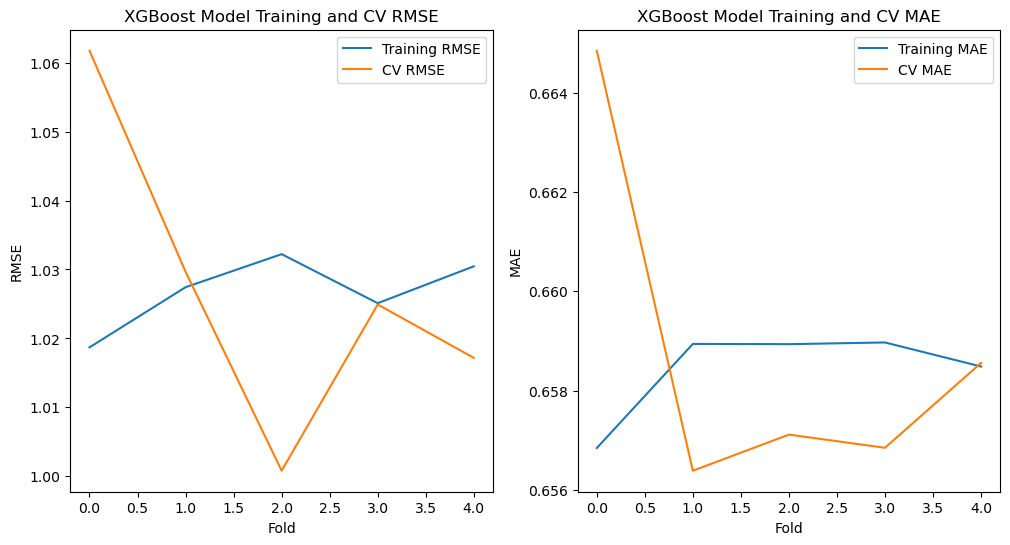

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  -0.1375818495106016
MSE:  1.331730137371436
RMSE:  1.1540061253613154


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.11666249512407467
MSE:  1.1166624951240747
RMSE:  1.056722525133289


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -0.259942123750047
MSE:  4.776997711425877
RMSE:  2.185634395644861


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 1.0567
MAE: 0.5369
R2: -0.1167


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 8.2560
MAE: 4.3677
R2: -16.9777

Model-based Disaggregation Metrics:
RMSE: 2.1856
MAE: 1.0041
R2: -0.2599


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT11   
1                EU                AT               AT1              AT11   
2                EU                AT               AT1              AT11   
3                EU                AT               AT1              AT12   
4                EU                AT               AT1              AT12   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
0                AT111          -0.6024      0          -0.3793  
1                AT112           0.0200      1          -0.3790  
2                AT113          -0.4756      2          -0.3791  
3                AT121           1.0457      3          -0.3787  
4                AT122           0.0085      4          -0.3786  
...                ...              ...    ...              ...  
1165             SK023          -0.4756   1165          -0.3080  
1166             SK031          -0.3373   1166          -0.3079  
1167             SK032          -0.1990   1167          -0.3079  
1168             SK041          -0.2797   1168          -0.3078  
1169             SK042          -0.0031   1169          -0.3077  

[1170 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

### Hyperparameters Optimization - GridSearchCV

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [ ]:
# Initialize the SVM model
model = SVR()

# Define the parameter grid to search over
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 6)),
    'degree': [2, 3, 4]  # Only used if kernel='poly'
}

# Define custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Initialize the GridSearchCV object
grid_search_mae = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the data
grid_search_mae.fit(X_train, y_train)

# Print the best hyperparameters and CV score
print("Best hyperparameters:", grid_search_mae.best_params_)
print("Best CV score:", -grid_search_mae.best_score_)

## 2nd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The variable to disaggregate is:  fuel_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

In [ ]:
# Define model parameters for SVM
model_params = {
    'kernel': 'rbf',  # Radial basis function kernel for non-linear regression
    'C': 1,  # Regularization parameter (inverse of the regularization strength)
    'epsilon': 0.1,  # The epsilon-tube within which no penalty is associated with the training loss function
    'gamma': 'scale',  # Kernel coefficient
}

# Define a list of random states
random_states = [43,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_svm_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 43
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.1763, Mean CV RMSE: 0.5525
Mean Train MAE: 0.1185, Mean CV MAE: 0.2882
Mean Train R2: 0.9748


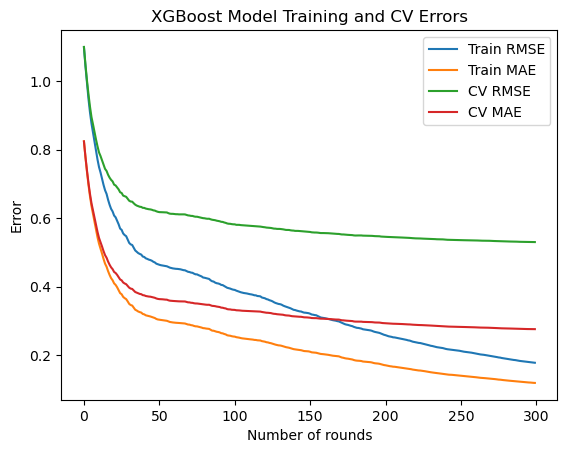

In [ ]:
plot_cv_error(model)

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.5328231552344999
MSE:  0.24787018448767367
RMSE:  0.49786562894788555


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.27495739426716803
MSE:  0.725042605732832
RMSE:  0.8514943368765479


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -6.388562515049233
MSE:  0.39983438123452797
RMSE:  0.6323245853472155


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.2149
MAE: 0.5959
R2: -0.4759

Model-based Disaggregation Metrics:
RMSE: 0.8515
MAE: 0.4995
R2: 0.2750


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6383
MAE: 0.2676
R2: -6.5290

Model-based Disaggregation Metrics:
RMSE: 0.6323
MAE: 0.4224
R2: -6.3886


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT11   
1                EU                AT               AT1              AT11   
2                EU                AT               AT1              AT11   
3                EU                AT               AT1              AT12   
4                EU                AT               AT1              AT12   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
0                AT111          -0.7622      0          -0.7055  
1                AT112          -0.3546      1          -0.4426  
2                AT113          -0.5132      2          -0.6390  
3                AT121           0.3322      3          -0.2463  
4                AT122          -0.1810      4          -0.2501  
...                ...              ...    ...              ...  
1165             SK023           0.0907   1165           0.5188  
1166             SK031           0.0378   1166           0.5856  
1167             SK032          -0.0527   1167           0.5201  
1168             SK041          -0.0225   1168           0.8498  
1169             SK042          -0.0905   1169           0.7616  

[1170 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

## 3rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  fuel_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 300, # Increased number of trees
    'max_depth': 8,  # Reduced maximum depth
    'learning_rate': 0.09,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased L1 regularization
    'reg_lambda': 0.6,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [44,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 44
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.1819, Mean CV RMSE: 0.5448
Mean Train MAE: 0.1219, Mean CV MAE: 0.2866
Mean Train R2: 0.9732


In [ ]:
plot_cv_error(model)

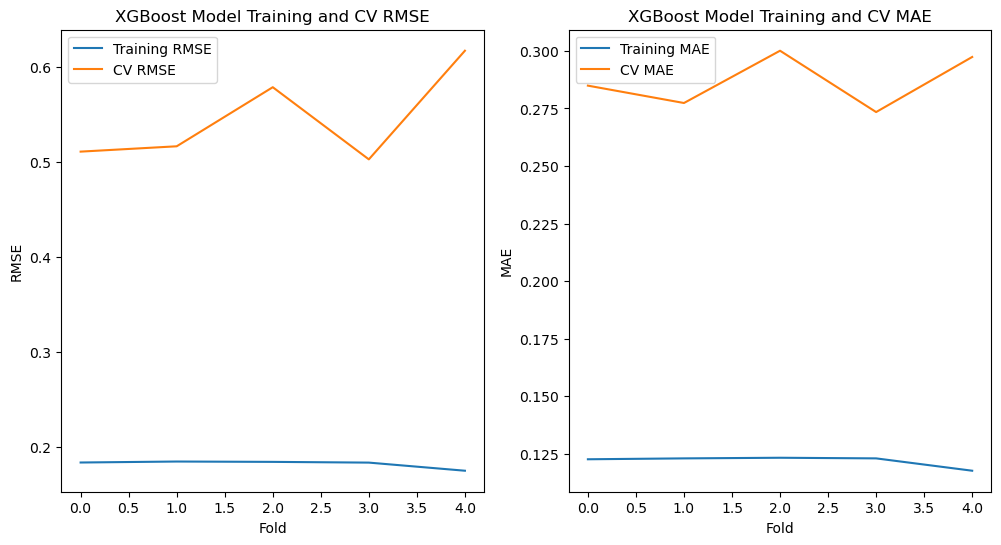

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.3979244387536707
MSE:  0.3194434444124832
RMSE:  0.5651932805797351


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.28332799848410584
MSE:  0.7166720015158942
RMSE:  0.8465648241664038


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -7.34429675709109
MSE:  0.451554239936828
RMSE:  0.6719778567310295


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.2149
MAE: 0.5959
R2: -0.4759

Model-based Disaggregation Metrics:
RMSE: 0.8466
MAE: 0.5167
R2: 0.2833


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6383
MAE: 0.2676
R2: -6.5290

Model-based Disaggregation Metrics:
RMSE: 0.6720
MAE: 0.4801
R2: -7.3443


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT11   
1                EU                AT               AT1              AT11   
2                EU                AT               AT1              AT11   
3                EU                AT               AT1              AT12   
4                EU                AT               AT1              AT12   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
0                AT111          -0.7622      0          -0.7025  
1                AT112          -0.3546      1          -0.4884  
2                AT113          -0.5132      2          -0.6520  
3                AT121           0.3322      3          -0.2324  
4                AT122          -0.1810      4          -0.2561  
...                ...              ...    ...              ...  
1165             SK023           0.0907   1165           0.5938  
1166             SK031           0.0378   1166           0.6585  
1167             SK032          -0.0527   1167           0.6093  
1168             SK041          -0.0225   1168           0.8469  
1169             SK042          -0.0905   1169           0.7823  

[1170 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

## 4rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  fuel_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 300, # Increased number of trees
    'max_depth': 8,  # Reduced maximum depth
    'learning_rate': 0.09,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased L1 regularization
    'reg_lambda': 0.6,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [45,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 45
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.1796, Mean CV RMSE: 0.5533
Mean Train MAE: 0.1206, Mean CV MAE: 0.2878
Mean Train R2: 0.9739


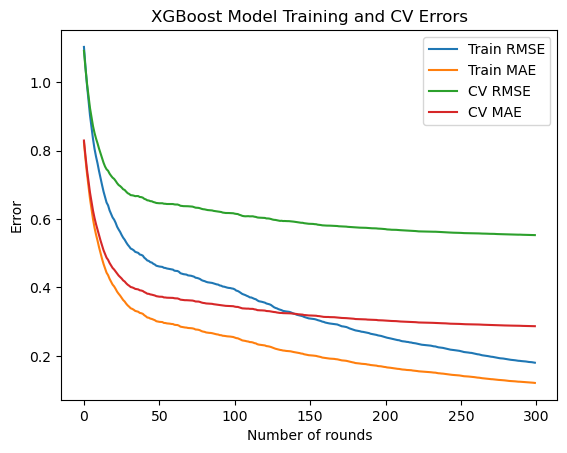

In [ ]:
plot_cv_error(model)

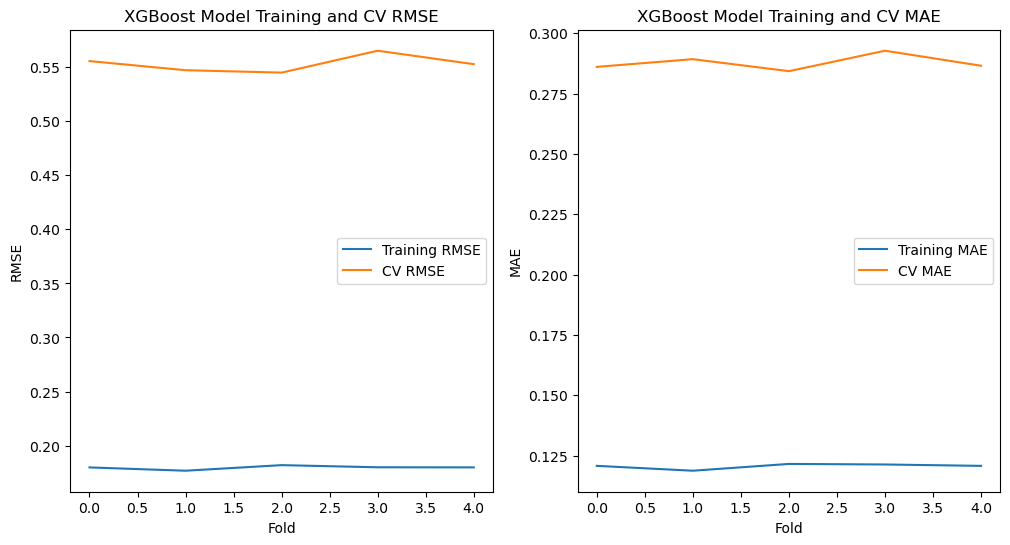

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.3659688844270972
MSE:  0.3363981142234613
RMSE:  0.5799983743282918


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.25844398283022185
MSE:  0.7415560171697781
RMSE:  0.861136468377561


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -8.168039367902704
MSE:  0.49613133005679716
RMSE:  0.7043659063702595


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.2149
MAE: 0.5959
R2: -0.4759

Model-based Disaggregation Metrics:
RMSE: 0.8611
MAE: 0.5291
R2: 0.2584


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6383
MAE: 0.2676
R2: -6.5290

Model-based Disaggregation Metrics:
RMSE: 0.7044
MAE: 0.5106
R2: -8.1680


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT11   
1                EU                AT               AT1              AT11   
2                EU                AT               AT1              AT11   
3                EU                AT               AT1              AT12   
4                EU                AT               AT1              AT12   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
0                AT111          -0.7622      0          -0.6891  
1                AT112          -0.3546      1          -0.4375  
2                AT113          -0.5132      2          -0.6388  
3                AT121           0.3322      3          -0.2026  
4                AT122          -0.1810      4          -0.2468  
...                ...              ...    ...              ...  
1165             SK023           0.0907   1165           0.5170  
1166             SK031           0.0378   1166           0.5891  
1167             SK032          -0.0527   1167           0.5526  
1168             SK041          -0.0225   1168           0.8124  
1169             SK042          -0.0905   1169           0.7968  

[1170 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

## 5th Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 0
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  fuel_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_8208\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 300, # Increased number of trees
    'max_depth': 8,  # Reduced maximum depth
    'learning_rate': 0.09,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased L1 regularization
    'reg_lambda': 0.6,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [46,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 46
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.1815, Mean CV RMSE: 0.5621
Mean Train MAE: 0.1217, Mean CV MAE: 0.2891
Mean Train R2: 0.9733


In [ ]:
plot_cv_error(model)

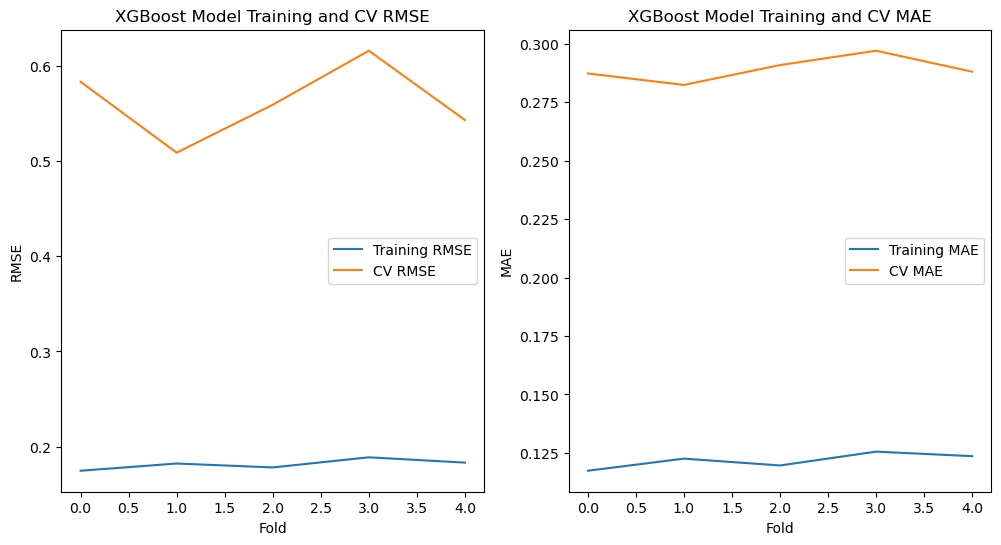

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.17145788896197545
MSE:  0.43959988218570173
RMSE:  0.6630232893237625


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.23289333777067212
MSE:  0.7671066622293279
RMSE:  0.8758462549039802


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -10.613655642774097
MSE:  0.6284766229346201
RMSE:  0.7927651751525291


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.2149
MAE: 0.5959
R2: -0.4759

Model-based Disaggregation Metrics:
RMSE: 0.8758
MAE: 0.5439
R2: 0.2329


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6383
MAE: 0.2676
R2: -6.5290

Model-based Disaggregation Metrics:
RMSE: 0.7928
MAE: 0.5634
R2: -10.6137


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT11   
1                EU                AT               AT1              AT11   
2                EU                AT               AT1              AT11   
3                EU                AT               AT1              AT12   
4                EU                AT               AT1              AT12   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
0                AT111          -0.7622      0          -0.7109  
1                AT112          -0.3546      1          -0.4353  
2                AT113          -0.5132      2          -0.6047  
3                AT121           0.3322      3          -0.2055  
4                AT122          -0.1810      4          -0.2339  
...                ...              ...    ...              ...  
1165             SK023           0.0907   1165           0.5443  
1166             SK031           0.0378   1166           0.5799  
1167             SK032          -0.0527   1167           0.5485  
1168             SK041          -0.0225   1168           0.8682  
1169             SK042          -0.0905   1169           0.8439  

[1170 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                 EU                AT               AT1              AT11   
1                 EU                AT               AT1              AT11   
2                 EU                AT               AT1              AT11   
3                 EU                AT               AT1              AT12   
4                 EU                AT               AT1              AT12   
...              ...               ...               ...               ...   
25735             EU                SK               SK0              SK02   
25736             EU                SK               SK0              SK03   
25737             EU                SK               SK0              SK03   
25738             EU                SK               SK0              SK04   
25739             EU                SK               SK0              SK04   

      NUTS3_region_code  population_value  gross value added_value  \
0                 AT111           -0.7375                  -0.5166   
1                 AT112           -0.4757                  -0.3065   
2                 AT113           -0.6103                  -0.4337   
3                 AT121           -0.2895                  -0.1478   
4                 AT122           -0.2600                  -0.1568   
...                 ...               ...                      ...   
25735             SK023            0.6215                  -0.0935   
25736             SK031            0.6582                  -0.0603   
25737             SK032            0.5596                  -0.1837   
25738             SK041            0.9457                  -0.1526   
25739             SK042            0.8928                  -0.0435   

       number of pixels with continuous urban fabric_value  UMAP14  \
0                                                -0.3991    2.5034   
1                                                -0.2439    1.7273   
2                                                -0.2759    2.0076   
3                                                -0.1653    1.4261   
4                                                -0.3262    1.4276   
...                                                  ...       ...   
25735                                            -0.3482    0.6567   
25736                                            -0.3566    0.7656   
25737                                            -0.3519    0.5518   
25738                                            -0.3745    0.5133   
25739                                            -0.3257    0.4528   

       live births_value  ...  total employment_value  \
0                -0.7251  ...                 -0.6567   
1                -0.4910  ...                 -0.4315   
2                -0.6237  ...                 -0.5551   
3                -0.2422  ...                 -0.2793   
4                -0.2736  ...                 -0.2748   
...                  ...  ...                     ...   
25735             0.5471  ...                  0.4911   
25736             0.8446  ...                  0.5735   
25737             0.5231  ...                  0.3089   
25738             1.3811  ...                  0.4313   
25739             1.1474  ...                  0.4880   

       total number of businesses_value  number of pixels with airports_value  \
0                               -0.4230                                0.3141   
1                               -0.2446                               -0.4824   
2                               -0.3438                               -0.6002   
3                               -0.1869                               -0.3539   
4                               -0.1408                               -0.4331   
...                                 ...                                   ...   
25735                            1.0187                               -0.5445   
25736                            1.2231               

# SVM Model Cluster 2

## 1st Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  fuel_stations_value


IndexError: list index out of range

In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 300, # Increased number of trees
    'max_depth': 8,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [47,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 47
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0577, Mean CV RMSE: 0.5746
Mean Train MAE: 0.0414, Mean CV MAE: 0.3221
Mean Train R2: 0.9968


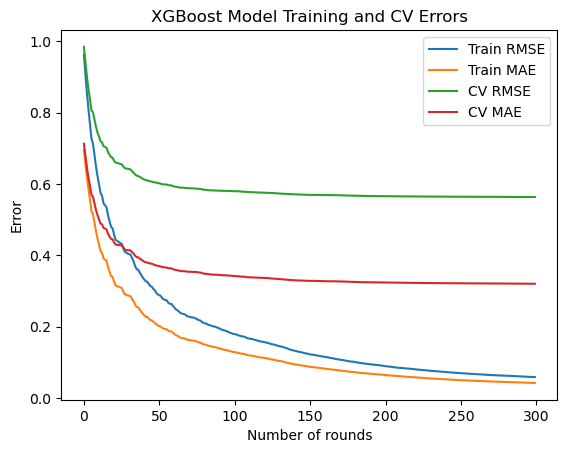

In [ ]:
plot_cv_error(model)

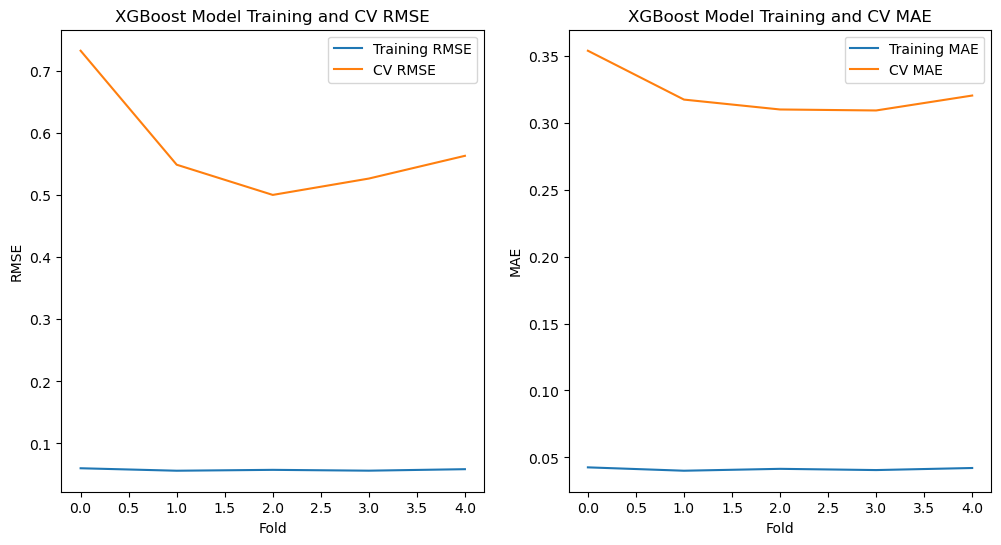

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.6527769545515337
MSE:  0.5834897334851046
RMSE:  0.7638649968974259


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.11503388663266945
MSE:  1.5957018645080268
RMSE:  1.2632109342892923


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.36805300476312663
MSE:  1.019343876095806
RMSE:  1.0096256118461961


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.5862
MAE: 1.0321
R2: -0.7582

Model-based Disaggregation Metrics:
RMSE: 1.2632
MAE: 0.8821
R2: -0.1150


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.0672
MAE: 0.8034
R2: 0.2939

Model-based Disaggregation Metrics:
RMSE: 1.0096
MAE: 0.8605
R2: 0.3681


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
3                EU                AT               AT1              AT12   
8                EU                AT               AT1              AT12   
12               EU                AT               AT2              AT21   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
3                AT121           1.0457      3          -0.1651  
8                AT126           0.5501      8           0.1083  
12               AT212           1.1149     12           0.2401  
21               AT312           1.3223     21           0.8736  
35               BE100           1.2416     35           2.0269  
...                ...              ...    ...              ...  
1165             SK023          -0.4756   1165           0.4735  
1166             SK031          -0.3373   1166           0.5837  
1167             SK032          -0.1990   1167           0.3143  
1168             SK041          -0.2797   1168           0.7658  
1169             SK042          -0.0031   1169           0.4996  

[256 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

## 2nd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [48,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 48
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0415, Mean CV RMSE: 0.6054
Mean Train MAE: 0.0290, Mean CV MAE: 0.3271
Mean Train R2: 0.9984


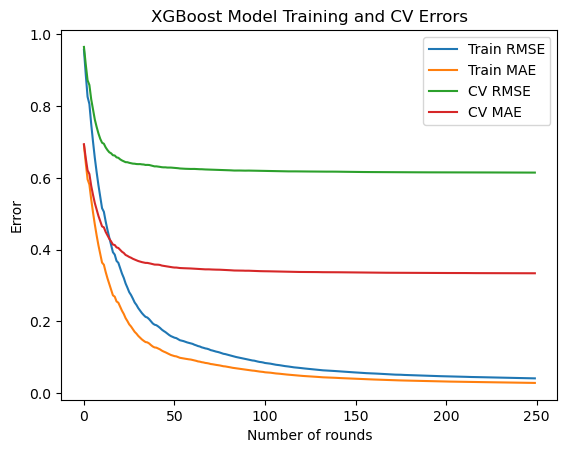

In [ ]:
plot_cv_error(model)

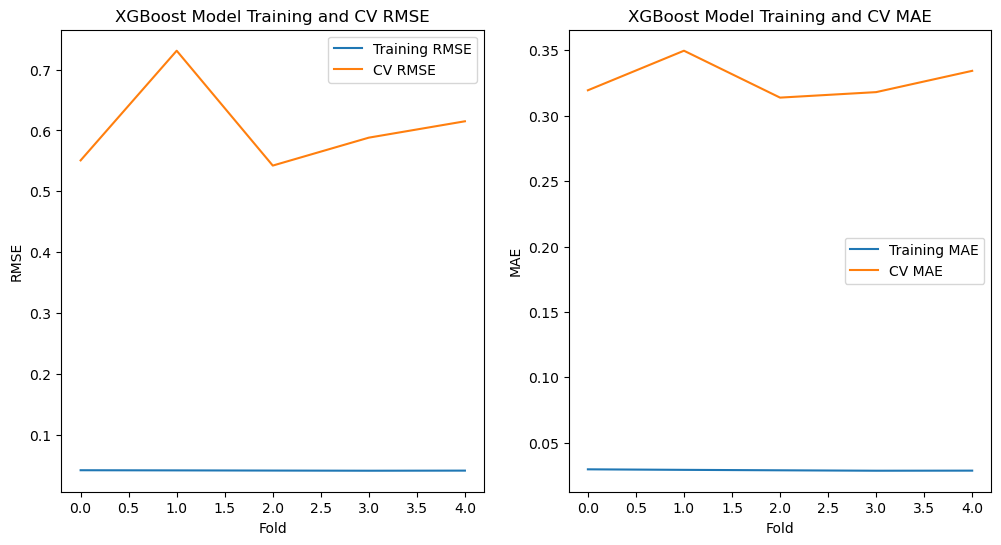

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.5687145890067402
MSE:  0.7247520370989319
RMSE:  0.8513236970147912


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.07487321212410891
MSE:  1.53822875632587
RMSE:  1.2402535048633687


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.27717215518827
MSE:  1.165936609611044
RMSE:  1.0797854461007723


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.5862
MAE: 1.0321
R2: -0.7582

Model-based Disaggregation Metrics:
RMSE: 1.2403
MAE: 0.8760
R2: -0.0749


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.0672
MAE: 0.8034
R2: 0.2939

Model-based Disaggregation Metrics:
RMSE: 1.0798
MAE: 0.8837
R2: 0.2772


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
3                EU                AT               AT1              AT12   
8                EU                AT               AT1              AT12   
12               EU                AT               AT2              AT21   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
3                AT121           1.0457      3          -0.1727  
8                AT126           0.5501      8          -0.0686  
12               AT212           1.1149     12          -0.0431  
21               AT312           1.3223     21           0.9454  
35               BE100           1.2416     35           2.2436  
...                ...              ...    ...              ...  
1165             SK023          -0.4756   1165           0.4679  
1166             SK031          -0.3373   1166           0.5925  
1167             SK032          -0.1990   1167           0.3410  
1168             SK041          -0.2797   1168           0.4367  
1169             SK042          -0.0031   1169           0.4602  

[256 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

## 3rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [49,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 49
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0413, Mean CV RMSE: 0.5767
Mean Train MAE: 0.0288, Mean CV MAE: 0.3187
Mean Train R2: 0.9984


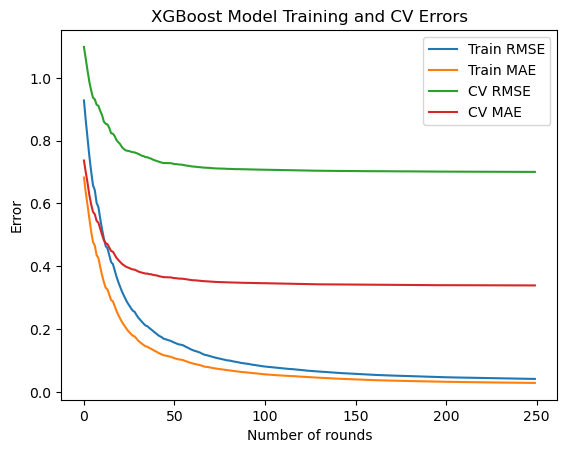

In [ ]:
plot_cv_error(model)

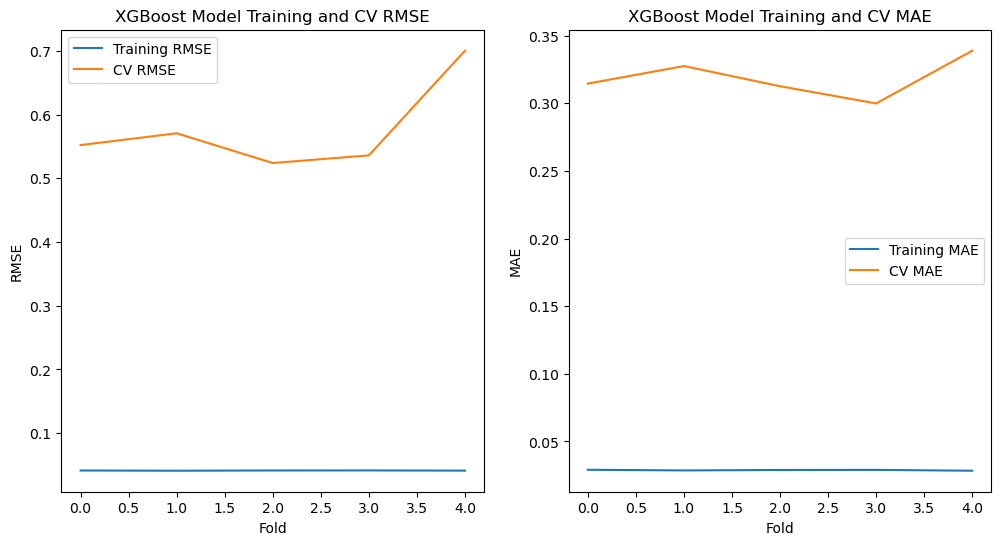

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.5210196945906956
MSE:  0.8049007530215
RMSE:  0.8971626123627199


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.0983221653178541
MSE:  1.5717860668081722
RMSE:  1.2537089242755561


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.18451730284310153
MSE:  1.3153908471348839
RMSE:  1.1469048989061315


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.5862
MAE: 1.0321
R2: -0.7582

Model-based Disaggregation Metrics:
RMSE: 1.2537
MAE: 0.8782
R2: -0.0983


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.0672
MAE: 0.8034
R2: 0.2939

Model-based Disaggregation Metrics:
RMSE: 1.1469
MAE: 0.9184
R2: 0.1845


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
3                EU                AT               AT1              AT12   
8                EU                AT               AT1              AT12   
12               EU                AT               AT2              AT21   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
3                AT121           1.0457      3          -0.2093  
8                AT126           0.5501      8          -0.1338  
12               AT212           1.1149     12           0.1894  
21               AT312           1.3223     21           0.9204  
35               BE100           1.2416     35           2.0640  
...                ...              ...    ...              ...  
1165             SK023          -0.4756   1165           0.4865  
1166             SK031          -0.3373   1166           0.5506  
1167             SK032          -0.1990   1167           0.3535  
1168             SK041          -0.2797   1168           0.4419  
1169             SK042          -0.0031   1169           0.4821  

[256 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

## 4rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [50,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 50
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0414, Mean CV RMSE: 0.5881
Mean Train MAE: 0.0289, Mean CV MAE: 0.3199
Mean Train R2: 0.9984


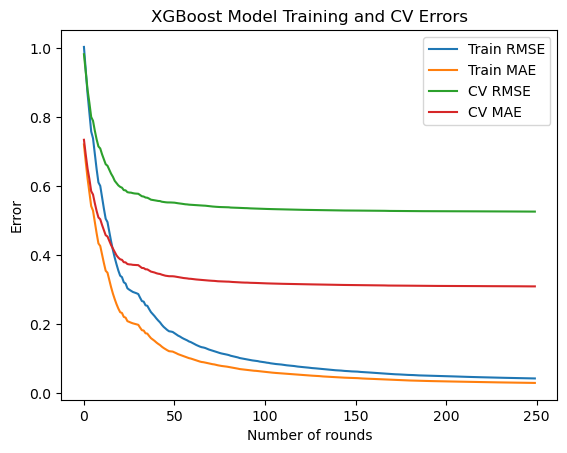

In [ ]:
plot_cv_error(model)

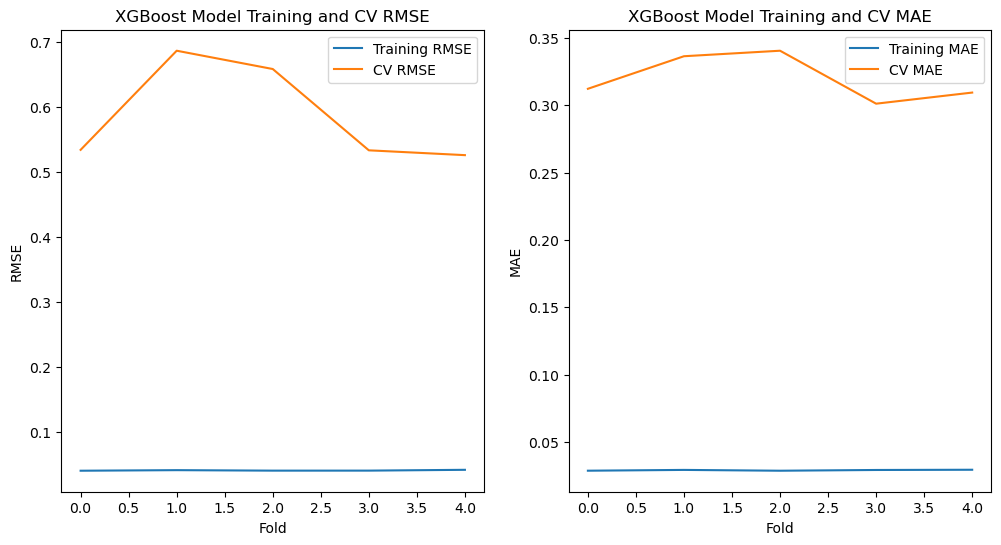

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.553208416285546
MSE:  0.750809329974691
RMSE:  0.8664925446734617


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.038689387930559205
MSE:  1.4864468361323548
RMSE:  1.2191992602246586


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.14127852952641218
MSE:  1.385135903480537
RMSE:  1.1769179680336845


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.5862
MAE: 1.0321
R2: -0.7582

Model-based Disaggregation Metrics:
RMSE: 1.2192
MAE: 0.8710
R2: -0.0387


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.0672
MAE: 0.8034
R2: 0.2939

Model-based Disaggregation Metrics:
RMSE: 1.1769
MAE: 0.9942
R2: 0.1413


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
3                EU                AT               AT1              AT12   
8                EU                AT               AT1              AT12   
12               EU                AT               AT2              AT21   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
3                AT121           1.0457      3          -0.2585  
8                AT126           0.5501      8          -0.1334  
12               AT212           1.1149     12           0.2757  
21               AT312           1.3223     21           0.8297  
35               BE100           1.2416     35           2.4560  
...                ...              ...    ...              ...  
1165             SK023          -0.4756   1165           0.4414  
1166             SK031          -0.3373   1166           0.5562  
1167             SK032          -0.1990   1167           0.3279  
1168             SK041          -0.2797   1168           0.4191  
1169             SK042          -0.0031   1169           0.4597  

[256 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

## 5th Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 1
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [51,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 51
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0414, Mean CV RMSE: 0.5683
Mean Train MAE: 0.0289, Mean CV MAE: 0.3208
Mean Train R2: 0.9984


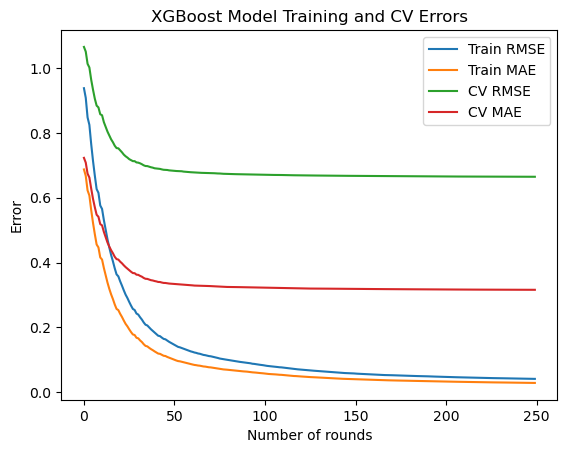

In [ ]:
plot_cv_error(model)

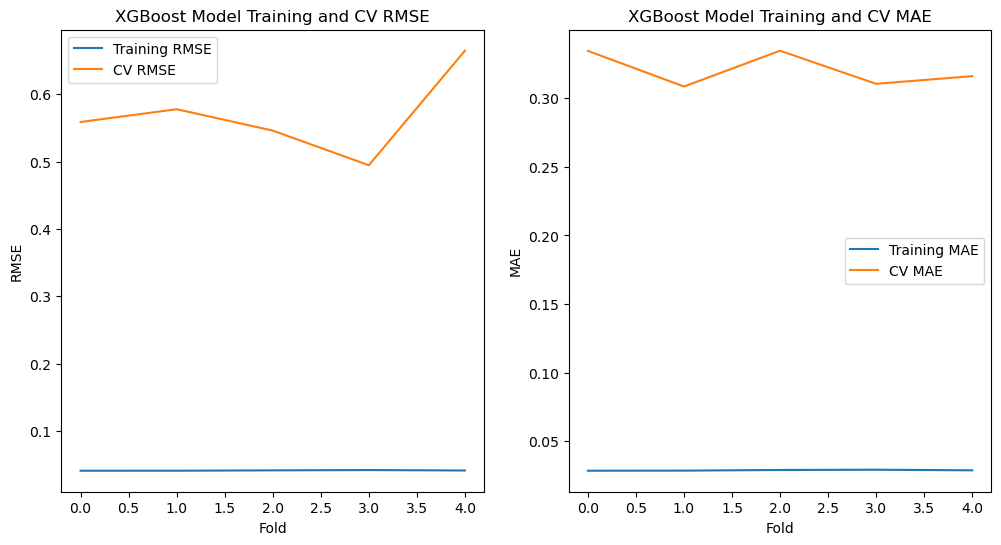

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.5719102810658043
MSE:  0.7193818477284787
RMSE:  0.848163809489935


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.05258886598867463
MSE:  1.5063380908457016
RMSE:  1.2273296585863562


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.340053048460878
MSE:  1.064508398124982
RMSE:  1.0317501626483914


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.5862
MAE: 1.0321
R2: -0.7582

Model-based Disaggregation Metrics:
RMSE: 1.2273
MAE: 0.8735
R2: -0.0526


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.0672
MAE: 0.8034
R2: 0.2939

Model-based Disaggregation Metrics:
RMSE: 1.0318
MAE: 0.8198
R2: 0.3401


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
3                EU                AT               AT1              AT12   
8                EU                AT               AT1              AT12   
12               EU                AT               AT2              AT21   
21               EU                AT               AT3              AT31   
35               EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
1165             EU                SK               SK0              SK02   
1166             EU                SK               SK0              SK03   
1167             EU                SK               SK0              SK03   
1168             EU                SK               SK0              SK04   
1169             EU                SK               SK0              SK04   

     NUTS3_region_code  target_variable  index  predicted_value  
3                AT121           1.0457      3          -0.2335  
8                AT126           0.5501      8          -0.1481  
12               AT212           1.1149     12          -0.1138  
21               AT312           1.3223     21           0.9164  
35               BE100           1.2416     35           1.9686  
...                ...              ...    ...              ...  
1165             SK023          -0.4756   1165           0.4478  
1166             SK031          -0.3373   1166           0.2825  
1167             SK032          -0.1990   1167           0.2825  
1168             SK041          -0.2797   1168           0.4018  
1169             SK042          -0.0031   1169           0.4466  

[256 rows x 8 columns]

In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0                EU                AT               AT1              AT12   
1                EU                AT               AT1              AT12   
2                EU                AT               AT2              AT21   
3                EU                AT               AT3              AT31   
4                EU                BE               BE1              BE10   
...             ...               ...               ...               ...   
4603             EU                SK               SK0              SK02   
4604             EU                SK               SK0              SK03   
4605             EU                SK               SK0              SK03   
4606             EU                SK               SK0              SK04   
4607             EU                SK               SK0              SK04   

     NUTS3_region_code  total employment_value  fuel_stations_value  \
0                AT121                 -0.1434               0.3322   
1                AT126                 -0.0529               0.4605   
2                AT212                 -0.2740               0.3247   
3                AT312                  0.2248               1.3965   
4                BE100                  1.3935               0.4605   
...                ...                     ...                  ...   
4603             SK023                  0.4911               0.0907   
4604             SK031                  0.5735               0.0378   
4605             SK032                  0.3089              -0.0527   
4606             SK041                  0.4313              -0.0225   
4607             SK042                  0.4880              -0.0905   

      railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   -0.0976  0.8452               1.2730  ... -0.4955   
1                    0.3422  0.0638               1.7374  ... -0.6097   
2                    3.0469  0.5699               0.9014  ... -0.2565   
3                    1.0370 -0.8705               0.9943  ... -0.5654   
4                    4.9863 -1.3013               0.1582  ... -0.7125   
...                     ...     ...                  ...  ...     ...   
4603                 0.1355  1.7646               1.5052  ... -0.5057   
4604                 0.7644  1.4391               1.8768  ... -0.5425   
4605                 1.3713  1.8279               0.8549  ... -0.5045   
4606                 1.0810  1.5637               0.9943  ... -0.5446   
4607                 1.4416  1.6269               0.9014  ... -0.5433   

      gross domestic product_value   UMAP1  centroid_x  UMAP3  \
0                          -0.1480 -0.1530      0.3904 0.6760   
1                          -0.0973 -0.1214      0.5173 0.2089   
2                          -0.3904  0.0245      0.2401 0.8283   
3                           1.0166  0.1073      0.3077 0.0164   
4                           3.5946  0.1702     -0.5939 0.0678   
...                            ...     ...         ...    ...   
4603                       -0.0934 -0.3959      0.7041 0.3953   
4604                       -0.0601 -0.3218      0.7681 0.4712   
4605                       -0.1840 -0.4084      0.8101 0.3711   
4606                       -0.1528 -0.3921      0.9583 0.3443   
4607                       -0.0432 -0.4034      0.9713 0.3184   

      number of pixels with mineral extraction sites_value  \
0                                                2.6625      
1                                                0.9210      
2                                                0.4806      
3                                                0.7529      
4                                                1.2810      
...                                                 ...      
4603                                            -0.3253      
4604                                             0.0018      
4605       

# SVM Model Cluster 3

## 1st Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Check if cluster exists
cluster_df_region = cluster_df.loc[cluster_df['NUTS0_region_code'] == region, :].copy()

try:
    if cluster_df_region.empty:
        warnings.warn(f"The cluster doesn't contain the region '{region}'.")
        # Stop the runtime (you can also remove this line if you want the code to continue executing)
        raise SystemExit("The cluster doesn't contain the specified region.")
except SystemExit as e:
    print(e)

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region)

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [52,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 52
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0720, Mean CV RMSE: 1.6569
Mean Train MAE: 0.0455, Mean CV MAE: 1.0497
Mean Train R2: 0.9992


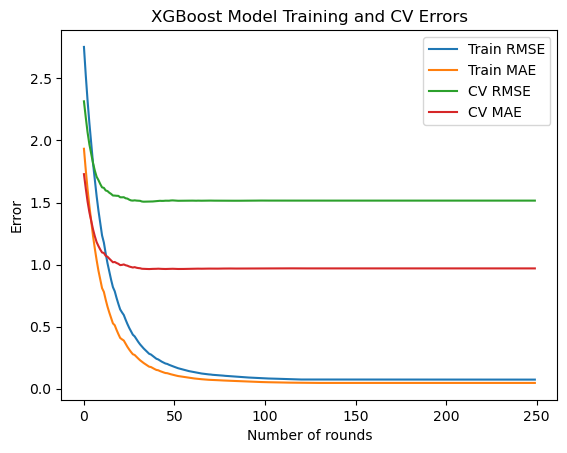

In [ ]:
plot_cv_error(model)

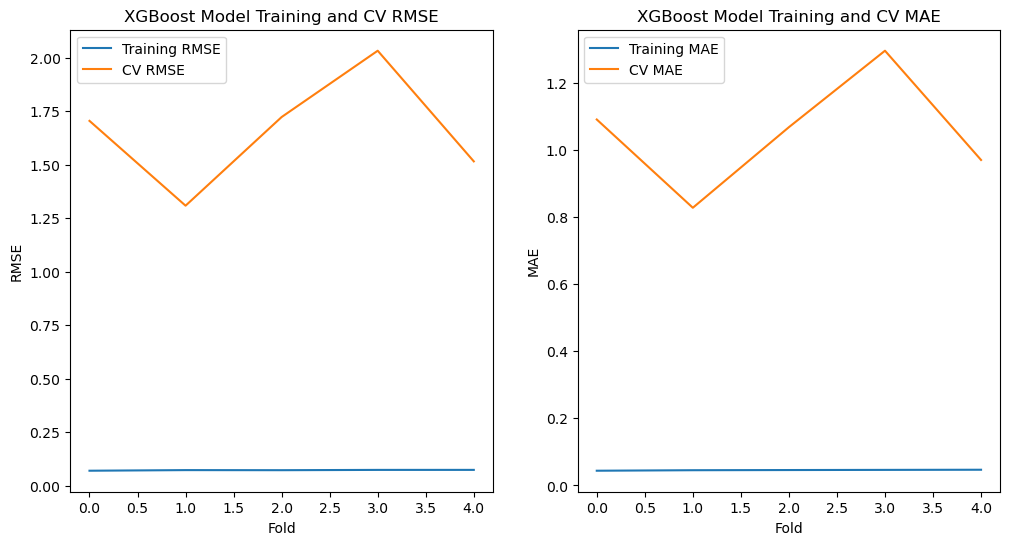

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.44166845440117963
MSE:  4.640243404088266
RMSE:  2.1541224208684766


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -1.117097827479804
MSE:  11.792396188725629
RMSE:  3.4340058515858165


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -22.68064401535917
MSE:  15.17311452123957
RMSE:  3.895268221989286


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.4225
MAE: 0.9685
R2: 0.6367

Model-based Disaggregation Metrics:
RMSE: 3.4340
MAE: 2.6560
R2: -1.1171


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.5883
MAE: 3.3756
R2: -19.0953

Model-based Disaggregation Metrics:
RMSE: 3.8953
MAE: 3.7568
R2: -22.6806


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
108              EU                CZ               CZ0              CZ01   
109              EU                CZ               CZ0              CZ02   
167              EU                DE               DE2              DE21   
262              EU                DE               DE3              DE30   
283              EU                DE               DE6              DE60   
606              EU                ES               ES3              ES30   
623              EU                ES               ES5              ES51   
627              EU                ES               ES5              ES52   
629              EU                ES               ES5              ES52   
640              EU                ES               ES6              ES61   
656              EU                FI               FI1              FI1B   
670              EU                FR               FR1              FR10   
672              EU                FR               FR1              FR10   
674              EU                FR               FR1              FR10   
675              EU                FR               FR1              FR10   
679              EU                FR               FRB              FRB0   
697              EU                FR               FRE              FRE1   
698              EU                FR               FRE              FRE1   
712              EU                FR               FRG              FRG0   
722              EU                FR               FRI              FRI1   
740              EU                FR               FRJ              FRJ2   
753              EU                FR               FRK              FRK2   
755              EU                FR               FRK              FRK2   
761              EU                FR               FRL              FRL0   
792              EU                HU               HU1              HU11   
817              EU                IE               IE0              IE06   
820              EU                IT               ITC              ITC1   
843              EU                IT               ITC              ITC4   
853              EU                IT               ITF              ITF3   
927              EU                IT               ITI              ITI4   
973              EU                NL               NL3              NL32   
1053             EU                PL               PL9              PL91   
1065             EU                PT               PT1              PT11   
1079             EU                PT               PT1              PT17   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.4333  
108              CZ010           1.3799    108           2.7155  
109              CZ020           0.2735    109           2.5829  
167              DE212           6.1282    167           2.3939  
262              DE300           6.5431    262           4.0356  
283              DE600           7.9952    283           2.9666  
606              ES300           1.3453    606          12.9565  
623              ES511           3.7771    623           9.7516  
627              ES521           0.8728    627           2.1975  
629              ES523           0.4464    629           3.6413  
640              ES618           0.6654    640           2.3123  
656              FI1B1           1.2992    656           3.0575  
670              FR101           1.3223    670           6.2251  


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

## 2nd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [53,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 53
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0731, Mean CV RMSE: 1.6150
Mean Train MAE: 0.0476, Mean CV MAE: 1.0208
Mean Train R2: 0.9992


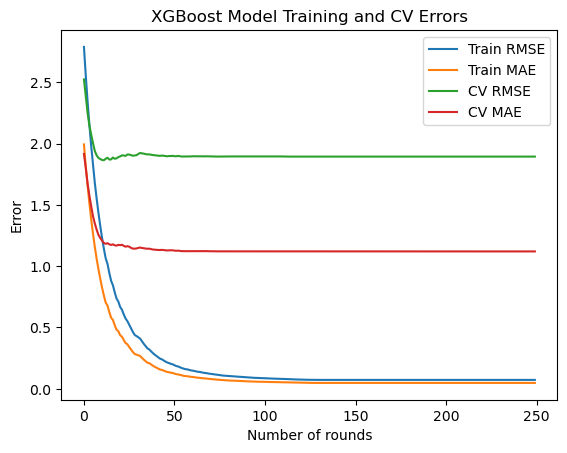

In [ ]:
plot_cv_error(model)

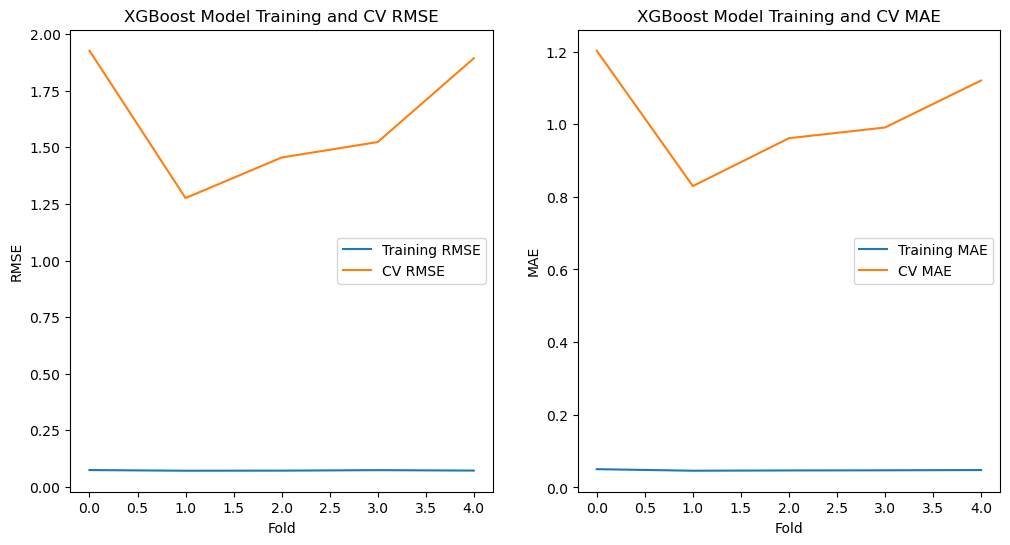

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.45335758848643937
MSE:  4.543096058991625
RMSE:  2.1314539776855668


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -1.142151859278576
MSE:  11.931949054569222
RMSE:  3.4542653422354834


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -19.80331608523842
MSE:  13.329498014417927
RMSE:  3.6509585062580383


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.4225
MAE: 0.9685
R2: 0.6367

Model-based Disaggregation Metrics:
RMSE: 3.4543
MAE: 2.6814
R2: -1.1422


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.5883
MAE: 3.3756
R2: -19.0953

Model-based Disaggregation Metrics:
RMSE: 3.6510
MAE: 2.9752
R2: -19.8033


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
108              EU                CZ               CZ0              CZ01   
109              EU                CZ               CZ0              CZ02   
167              EU                DE               DE2              DE21   
262              EU                DE               DE3              DE30   
283              EU                DE               DE6              DE60   
606              EU                ES               ES3              ES30   
623              EU                ES               ES5              ES51   
627              EU                ES               ES5              ES52   
629              EU                ES               ES5              ES52   
640              EU                ES               ES6              ES61   
656              EU                FI               FI1              FI1B   
670              EU                FR               FR1              FR10   
672              EU                FR               FR1              FR10   
674              EU                FR               FR1              FR10   
675              EU                FR               FR1              FR10   
679              EU                FR               FRB              FRB0   
697              EU                FR               FRE              FRE1   
698              EU                FR               FRE              FRE1   
712              EU                FR               FRG              FRG0   
722              EU                FR               FRI              FRI1   
740              EU                FR               FRJ              FRJ2   
753              EU                FR               FRK              FRK2   
755              EU                FR               FRK              FRK2   
761              EU                FR               FRL              FRL0   
792              EU                HU               HU1              HU11   
817              EU                IE               IE0              IE06   
820              EU                IT               ITC              ITC1   
843              EU                IT               ITC              ITC4   
853              EU                IT               ITF              ITF3   
927              EU                IT               ITI              ITI4   
973              EU                NL               NL3              NL32   
1053             EU                PL               PL9              PL91   
1065             EU                PT               PT1              PT11   
1079             EU                PT               PT1              PT17   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.3525  
108              CZ010           1.3799    108           3.3382  
109              CZ020           0.2735    109           2.2054  
167              DE212           6.1282    167           3.4302  
262              DE300           6.5431    262           6.0099  
283              DE600           7.9952    283           2.3009  
606              ES300           1.3453    606          13.3318  
623              ES511           3.7771    623           9.1411  
627              ES521           0.8728    627           2.0129  
629              ES523           0.4464    629           3.4807  
640              ES618           0.6654    640           2.6097  
656              FI1B1           1.2992    656           2.9267  
670              FR101           1.3223    670           4.2652  


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

## 3rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [54,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 54
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0729, Mean CV RMSE: 1.6780
Mean Train MAE: 0.0456, Mean CV MAE: 1.0177
Mean Train R2: 0.9992


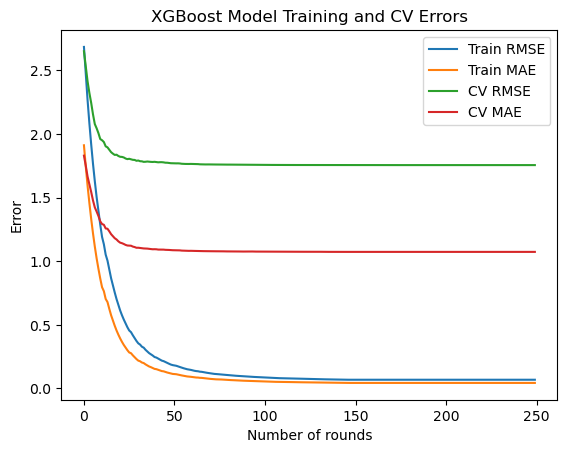

In [ ]:
plot_cv_error(model)

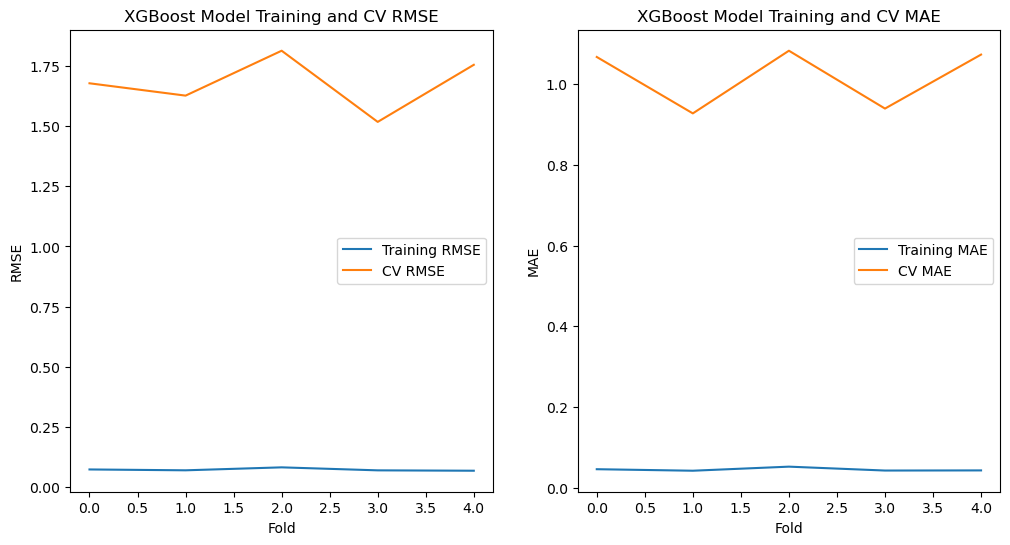

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.5046345640681242
MSE:  4.1169377134707466
RMSE:  2.0290238326522303


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -1.0185020819442174
MSE:  11.243210374642361
RMSE:  3.3530896759022655


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -35.51287369540457
MSE:  23.3952258106071
RMSE:  4.83686115271124


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.4225
MAE: 0.9685
R2: 0.6367

Model-based Disaggregation Metrics:
RMSE: 3.3531
MAE: 2.6265
R2: -1.0185


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.5883
MAE: 3.3756
R2: -19.0953

Model-based Disaggregation Metrics:
RMSE: 4.8369
MAE: 4.6204
R2: -35.5129


In [ ]:
df_eu_apply_targets

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
108              EU                CZ               CZ0              CZ01   
109              EU                CZ               CZ0              CZ02   
167              EU                DE               DE2              DE21   
262              EU                DE               DE3              DE30   
283              EU                DE               DE6              DE60   
606              EU                ES               ES3              ES30   
623              EU                ES               ES5              ES51   
627              EU                ES               ES5              ES52   
629              EU                ES               ES5              ES52   
640              EU                ES               ES6              ES61   
656              EU                FI               FI1              FI1B   
670              EU                FR               FR1              FR10   
672              EU                FR               FR1              FR10   
674              EU                FR               FR1              FR10   
675              EU                FR               FR1              FR10   
679              EU                FR               FRB              FRB0   
697              EU                FR               FRE              FRE1   
698              EU                FR               FRE              FRE1   
712              EU                FR               FRG              FRG0   
722              EU                FR               FRI              FRI1   
740              EU                FR               FRJ              FRJ2   
753              EU                FR               FRK              FRK2   
755              EU                FR               FRK              FRK2   
761              EU                FR               FRL              FRL0   
792              EU                HU               HU1              HU11   
817              EU                IE               IE0              IE06   
820              EU                IT               ITC              ITC1   
843              EU                IT               ITC              ITC4   
853              EU                IT               ITF              ITF3   
927              EU                IT               ITI              ITI4   
973              EU                NL               NL3              NL32   
1053             EU                PL               PL9              PL91   
1065             EU                PT               PT1              PT11   
1079             EU                PT               PT1              PT17   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.0589  
108              CZ010           1.3799    108           3.5924  
109              CZ020           0.2735    109           1.8752  
167              DE212           6.1282    167           3.1675  
262              DE300           6.5431    262           2.0949  
283              DE600           7.9952    283           1.5428  
606              ES300           1.3453    606          12.6245  
623              ES511           3.7771    623           6.4383  
627              ES521           0.8728    627           1.9289  
629              ES523           0.4464    629           3.5420  
640              ES618           0.6654    640           1.7267  
656              FI1B1           1.2992    656           2.0051  
670              FR101           1.3223    670           4.7883  


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

## 4rd Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [55,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 55
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0700, Mean CV RMSE: 1.6537
Mean Train MAE: 0.0451, Mean CV MAE: 1.0402
Mean Train R2: 0.9993


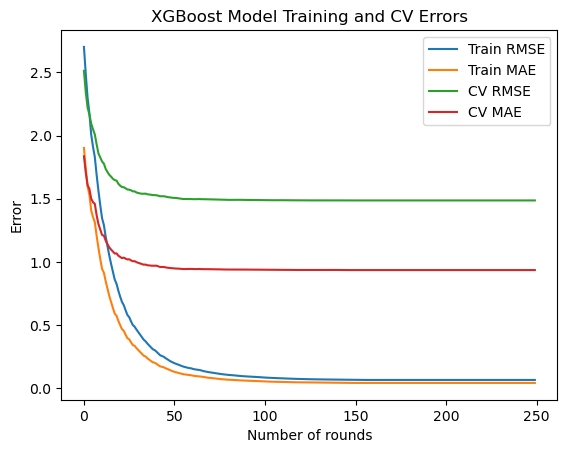

In [ ]:
plot_cv_error(model)

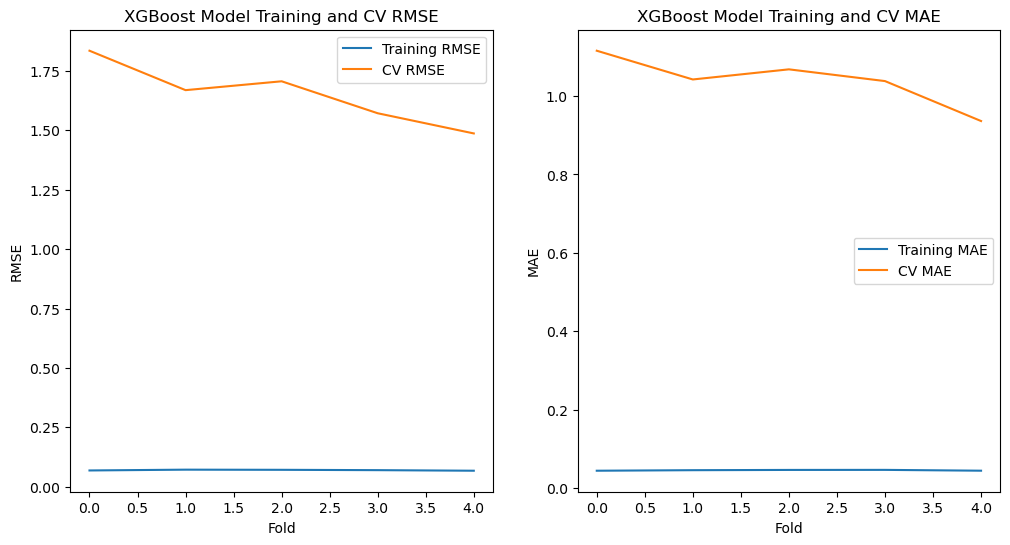

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.5194467146647348
MSE:  3.993835258221566
RMSE:  1.9984582202842185


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -1.065284978292805
MSE:  11.503794671427245
RMSE:  3.391724439194205


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -20.879152988537392
MSE:  14.01882878301288
RMSE:  3.744172643323606


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.4225
MAE: 0.9685
R2: 0.6367

Model-based Disaggregation Metrics:
RMSE: 3.3917
MAE: 2.6455
R2: -1.0653


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.5883
MAE: 3.3756
R2: -19.0953

Model-based Disaggregation Metrics:
RMSE: 3.7442
MAE: 3.2552
R2: -20.8792


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
108              EU                CZ               CZ0              CZ01   
109              EU                CZ               CZ0              CZ02   
167              EU                DE               DE2              DE21   
262              EU                DE               DE3              DE30   
283              EU                DE               DE6              DE60   
606              EU                ES               ES3              ES30   
623              EU                ES               ES5              ES51   
627              EU                ES               ES5              ES52   
629              EU                ES               ES5              ES52   
640              EU                ES               ES6              ES61   
656              EU                FI               FI1              FI1B   
670              EU                FR               FR1              FR10   
672              EU                FR               FR1              FR10   
674              EU                FR               FR1              FR10   
675              EU                FR               FR1              FR10   
679              EU                FR               FRB              FRB0   
697              EU                FR               FRE              FRE1   
698              EU                FR               FRE              FRE1   
712              EU                FR               FRG              FRG0   
722              EU                FR               FRI              FRI1   
740              EU                FR               FRJ              FRJ2   
753              EU                FR               FRK              FRK2   
755              EU                FR               FRK              FRK2   
761              EU                FR               FRL              FRL0   
792              EU                HU               HU1              HU11   
817              EU                IE               IE0              IE06   
820              EU                IT               ITC              ITC1   
843              EU                IT               ITC              ITC4   
853              EU                IT               ITF              ITF3   
927              EU                IT               ITI              ITI4   
973              EU                NL               NL3              NL32   
1053             EU                PL               PL9              PL91   
1065             EU                PT               PT1              PT11   
1079             EU                PT               PT1              PT17   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.3734  
108              CZ010           1.3799    108           3.2291  
109              CZ020           0.2735    109           1.8951  
167              DE212           6.1282    167           4.3171  
262              DE300           6.5431    262           4.4552  
283              DE600           7.9952    283           2.1286  
606              ES300           1.3453    606          12.4991  
623              ES511           3.7771    623          10.3407  
627              ES521           0.8728    627           1.8587  
629              ES523           0.4464    629           3.5064  
640              ES618           0.6654    640           2.1061  
656              FI1B1           1.2992    656           3.0687  
670              FR101           1.3223    670           5.4523  


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

## 5th Iteration

In [ ]:
print('The variable to disaggregate is: ', agg_var_to_disagg)

id_cluster = 2
cluster_name = cluster_names[id_cluster]
cluster_id = extract_cluster_id(cluster_name)
cluster_df = cluster_dfs[cluster_name]

# Create a new DataFrame with the first five columns
first_five_columns_df = cluster_df.iloc[:, :5].copy()

# Drop the first five columns and the 'Cluster' column from cluster_df
cluster_df = cluster_df.drop(columns=['Cluster']).iloc[:, 5:]

# Create a list of feature names from the modified DataFrame
feature_names_cluster_df = []
for col in cluster_df.columns:
    feature_names_cluster_df.append(col)

The variable to disaggregate is:  charging_stations_value


In [ ]:
master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu = create_master_dataframe_based_on_population_weights_v2(cluster_df, first_five_columns_df, feature_names_cluster_df, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu = prepare_data_for_cluster(cluster_id, master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The length of all ancilliary features + the aggregated feature is:  19
The length of all ancilliary features is:  18


C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_6332\1253404897.py:127: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

In [ ]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [56,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 56
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0706, Mean CV RMSE: 1.7134
Mean Train MAE: 0.0453, Mean CV MAE: 1.0493
Mean Train R2: 0.9992


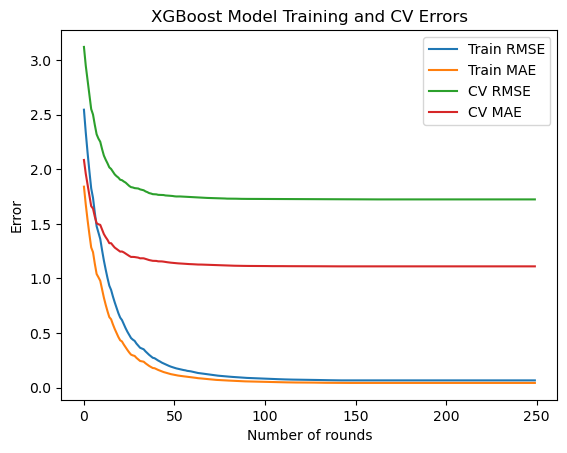

In [ ]:
plot_cv_error(model)

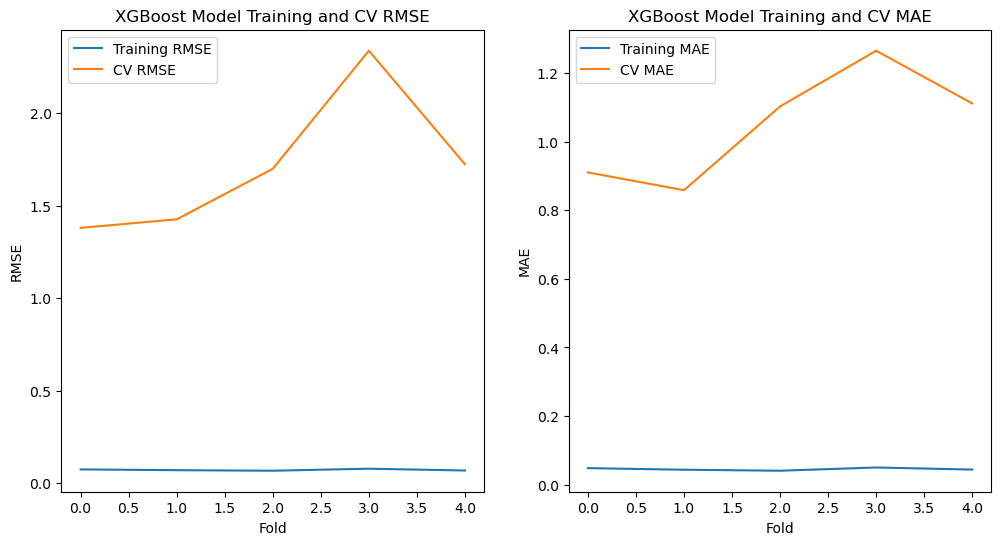

In [ ]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.47750700960903525
MSE:  4.342392385770922
RMSE:  2.0838407774518


In [ ]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -1.123183980357644
MSE:  11.826296523924631
RMSE:  3.4389382844018344


In [ ]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -18.05507750063785
MSE:  12.209333198064561
RMSE:  3.4941856273049607


In [ ]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [ ]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.4225
MAE: 0.9685
R2: 0.6367

Model-based Disaggregation Metrics:
RMSE: 3.4389
MAE: 2.7061
R2: -1.1232


In [ ]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 3.5883
MAE: 3.3756
R2: -19.0953

Model-based Disaggregation Metrics:
RMSE: 3.4942
MAE: 3.1666
R2: -18.0551


In [ ]:
df_eu_apply_target

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
10               EU                AT               AT1              AT13   
108              EU                CZ               CZ0              CZ01   
109              EU                CZ               CZ0              CZ02   
167              EU                DE               DE2              DE21   
262              EU                DE               DE3              DE30   
283              EU                DE               DE6              DE60   
606              EU                ES               ES3              ES30   
623              EU                ES               ES5              ES51   
627              EU                ES               ES5              ES52   
629              EU                ES               ES5              ES52   
640              EU                ES               ES6              ES61   
656              EU                FI               FI1              FI1B   
670              EU                FR               FR1              FR10   
672              EU                FR               FR1              FR10   
674              EU                FR               FR1              FR10   
675              EU                FR               FR1              FR10   
679              EU                FR               FRB              FRB0   
697              EU                FR               FRE              FRE1   
698              EU                FR               FRE              FRE1   
712              EU                FR               FRG              FRG0   
722              EU                FR               FRI              FRI1   
740              EU                FR               FRJ              FRJ2   
753              EU                FR               FRK              FRK2   
755              EU                FR               FRK              FRK2   
761              EU                FR               FRL              FRL0   
792              EU                HU               HU1              HU11   
817              EU                IE               IE0              IE06   
820              EU                IT               ITC              ITC1   
843              EU                IT               ITC              ITC4   
853              EU                IT               ITF              ITF3   
927              EU                IT               ITI              ITI4   
973              EU                NL               NL3              NL32   
1053             EU                PL               PL9              PL91   
1065             EU                PT               PT1              PT11   
1079             EU                PT               PT1              PT17   
1118             EU                RO               RO3              RO32   
1129             EU                SE               SE1              SE11   
1140             EU                SE               SE2              SE22   
1142             EU                SE               SE2              SE23   

     NUTS3_region_code  target_variable  index  predicted_value  
10               AT130           6.0014     10           3.5134  
108              CZ010           1.3799    108           3.0121  
109              CZ020           0.2735    109           1.8292  
167              DE212           6.1282    167           2.9485  
262              DE300           6.5431    262           5.1922  
283              DE600           7.9952    283           3.0260  
606              ES300           1.3453    606          12.1108  
623              ES511           3.7771    623           9.7143  
627              ES521           0.8728    627           1.8850  
629              ES523           0.4464    629           3.2697  
640              ES618           0.6654    640           2.0788  
656              FI1B1           1.2992    656           3.0723  
670              FR101           1.3223    670           6.3321  


In [ ]:
master_input_train_df

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0               EU                AT               AT1              AT13   
1               EU                CZ               CZ0              CZ01   
2               EU                CZ               CZ0              CZ02   
6               EU                ES               ES3              ES30   
7               EU                ES               ES5              ES51   
..             ...               ...               ...               ...   
697             EU                PT               PT1              PT17   
698             EU                RO               RO3              RO32   
699             EU                SE               SE1              SE11   
700             EU                SE               SE2              SE22   
701             EU                SE               SE2              SE23   

    NUTS3_region_code  total employment_value  fuel_stations_value  \
0               AT130                  3.5478               0.5888   
1               CZ010                  2.3845               0.5360   
2               CZ020                  2.5386               2.2192   
6               ES300                 11.9571               5.4346   
7               ES511                  9.8679               5.6158   
..                ...                     ...                  ...   
697             PT170                  5.1979               2.6192   
698             RO321                  3.6228               0.6190   
699             SE110                  4.6762               1.5701   
700             SE224                  1.8371               2.0380   
701             SE232                  2.8370               2.9891   

     railway_station_value  UMAP14  train_station_value  ...   UMAP2  \
0                   5.9055 -1.4570               6.7072  ... -0.5214   
1                   4.2299 -1.4945               0.1582  ... -0.6303   
2                   3.4207  1.7145               2.2483  ... -0.5237   
6                   6.5344 -1.6009               4.2920  ... -0.4847   
7                   5.3689 -1.6138               5.0816  ... -0.4687   
..                     ...     ...                  ...  ...     ...   
697                 2.7654 -1.4880               2.4806  ... -0.4068   
698                 1.6527 -1.3355               5.3138  ... -0.3335   
699                 3.1524 -1.3082               1.9232  ... -0.5632   
700                 1.2129 -1.1780               3.1773  ... -0.5208   
701                 2.5983 -1.0237               0.9478  ... -0.6087   

     gross domestic product_value   UMAP1  centroid_x   UMAP3  \
0                          4.1900  0.2620      0.5199 -0.3584   
1                          2.3598  0.2105      0.3227 -0.3392   
2                          0.7043 -0.4097      0.3312  0.2873   
6                         10.8865  0.2986     -1.5739 -0.5801   
7                          7.8901  0.3102     -0.9423 -0.5840   
..                            ...     ...         ...     ...   
697                        3.1129  0.3157     -2.1962 -0.4441   
698                        2.0686  0.3438      1.5427 -0.3085   
699                        6.6217  0.1979      0.5057 -0.5145   
700                        2.0379  0.1724      0.2011 -0.5568   
701                        3.2430  0.1328      0.1267 -0.5410   

     number of pixels with mineral extraction sites_value  bus_stations_value  \
0                                              -0.5675                 1.1445   
1                                              -0.4322                 0.7798   
2                                               0.9374                 5.1504   
6                                               1.4418                 5.1543   
7                                               1.7579                 3.7863   
..                                                 ...                    ...   
697                                  

# Hyperparameters Optimization - GridSearchCV

In [ ]:
# print('The variable to disaggregate is: ', agg_var_to_disagg)
# master_input_df, \
#     master_label_df, \
#         master_input_train_df, \
#             master_label_train_df, \
#                 master_input_test_df, \
#                     master_label_test_df, \
#                         df_apply_eu, \
#                             df_apply_region, \
#                                 df_eu_apply_target, \
#                                     df_region_apply_target, \
#                                         disagg_metric_population, \
#                                             disagg_metric_population_eu \
#                 = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region)


# X_train, X_test, y_train, y_test, \
# X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
#         y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
#     df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
#         disagg_metric_population, disagg_metric_population_eu)

# # save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# # X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

# X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [ ]:
# # Initialize the XGBoost model
# model = XGBRegressor(random_state=42)

# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.5, 1, 1.5],  # L1 regularization
#     'reg_lambda': [0, 0.5, 1, 1.5]  # L2 regularization
# }

# # Define custom scorer
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# # Initialize the GridSearchCV object
# grid_search_mae = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     n_jobs=-1
# )

# # Fit the GridSearchCV object to the data
# grid_search_mae.fit(X_train, y_train)

# # Print the best hyperparameters and CV score
# print("Best hyperparameters:", grid_search_mae.best_params_)
# print("Best CV score:", -grid_search_mae.best_score_)